# FDA Adverse Events & Recalls - Data Cleaning & Exploration

This notebook performs comprehensive data cleaning and exploratory data analysis
on FDA adverse events data (Drugs, Medical Devices, Biologics) and recall data.


# Import Libraries

In [61]:
# Setup and Imports
import sys
import subprocess
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Install missing packages
import sys
import subprocess

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("✓ Visualization libraries imported")
except ImportError:
    print("Installing visualization libraries...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib", "seaborn"])

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Setup paths
BASE_DIR = Path("/Users/Kay Michnicki/AllCode/FDA Data Scraping")
AE_DATA_DIR = BASE_DIR / "fda_adverse_events_recalls" / "adverse_events"
RECALLS_DATA_DIR = BASE_DIR / "fda_adverse_events_recalls" / "recalls"
OUTPUT_DIR = BASE_DIR / "fda_adverse_events_recalls" / "adverse_events_recalls_cleaned"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("FDA ADVERSE EVENTS & RECALLS - DATA CLEANING & EXPLORATION")
print(f"Adverse Events directory: {AE_DATA_DIR}")
print(f"Recalls directory: {RECALLS_DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

✓ Visualization libraries imported
FDA ADVERSE EVENTS & RECALLS - DATA CLEANING & EXPLORATION
Adverse Events directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/adverse_events
Recalls directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/recalls
Output directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/adverse_events_recalls_cleaned


In [62]:
import numpy as np
import pandas as pd
import matplotlib as mpl

print(f"NumPy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"Matplotlib version: {mpl.__version__}")

NumPy version: 1.26.4
pandas version: 2.3.3
Matplotlib version: 3.10.7


In [63]:
!pip freeze | grep -E 'numpy|pandas|matplotlib'

geopandas==1.1.1
matplotlib==3.10.7
matplotlib-inline==0.2.1
matplotlib-venn==1.1.2
numpy==1.26.4
pandas==2.3.3
pandas-datareader==0.10.0
pandas-gbq==0.29.2
pandas-stubs==2.2.2.240909
sklearn-pandas==2.2.0


## Load All Data


In [64]:
# Load All Adverse Events Data
print("\n" + "="*80)
print("LOADING ADVERSE EVENTS DATA FROM UPLOADED CSVs")
print("="*80)

# Load drug adverse events
drug_ae_path = "/content/drug_adverse_events.csv"
if Path(drug_ae_path).exists():
    drug_ae_df = pd.read_csv(drug_ae_path)
    print(f"\n✓ Drug Adverse Events: {len(drug_ae_df):,} records")
    print(f"  Columns ({len(drug_ae_df.columns)}): {list(drug_ae_df.columns)}")
else:
    drug_ae_df = None
    print("\n✗ Drug adverse events file not found at /content/drug_adverse_events.csv")

# Load device adverse events
device_ae_path = "/content/device_adverse_events.csv"
if Path(device_ae_path).exists():
    device_ae_df = pd.read_csv(device_ae_path)
    print(f"\n✓ Device Adverse Events: {len(device_ae_df):,} records")
    print(f"  Columns ({len(device_ae_df.columns)}): {list(device_ae_df.columns)}")
else:
    device_ae_df = None
    print("\n✗ Device adverse events file not found at /content/device_adverse_events.csv")

# Load biologics adverse events
biologics_ae_path = "/content/biologics_adverse_events.csv"
if Path(biologics_ae_path).exists():
    biologics_ae_df = pd.read_csv(biologics_ae_path)
    print(f"\n✓ Biologics Adverse Events: {len(biologics_ae_df):,} records")
    print(f"  Columns ({len(biologics_ae_df.columns)}): {list(biologics_ae_df.columns)}")
else:
    biologics_ae_df = None
    print("\n✗ Biologics adverse events file not found at /content/biologics_adverse_events.csv")

# Summary
total_ae_records = (len(drug_ae_df) if drug_ae_df is not None else 0) + \
                   (len(device_ae_df) if device_ae_df is not None else 0) + \
                   (len(biologics_ae_df) if biologics_ae_df is not None else 0)
print(f"Total Adverse Events Records: {total_ae_records:,}")


LOADING ADVERSE EVENTS DATA FROM UPLOADED CSVs

✓ Drug Adverse Events: 1,000 records
  Columns (17): ['safetyreportid', 'receivedate', 'serious', 'seriousnessdeath', 'seriousnesslifethreatening', 'seriousnesshospitalization', 'seriousnessdisabling', 'drug_product_name', 'drug_generic_name', 'drug_brand_name', 'adverse_reactions', 'reaction_count', 'patient_age', 'patient_age_unit', 'patient_sex', 'outcome', 'raw_data']

✓ Device Adverse Events: 1,000 records
  Columns (11): ['event_key', 'report_date', 'device_name', 'device_product_code', 'manufacturer', 'event_type', 'adverse_event_flag', 'product_problem_flag', 'device_problem', 'mdr_text', 'raw_data']

✓ Biologics Adverse Events: 51 records
  Columns (14): ['safetyreportid', 'receivedate', 'serious', 'biologics_product_name', 'biologics_generic_name', 'biologics_brand_name', 'biologics_product_names_all', 'biologics_count', 'adverse_reactions', 'reaction_count', 'patient_age', 'patient_sex', 'category', 'raw_data']
Total Adverse E

In [65]:
# Load All Adverse Events Data
print("LOADING ADVERSE EVENTS DATA FROM UPLOADED CSVs")

# Load drug adverse events
drug_ae_path = "/content/drug_adverse_events.csv"
if Path(drug_ae_path).exists():
    drug_ae_df = pd.read_csv(drug_ae_path)
    print(f"\n✓ Drug Adverse Events: {len(drug_ae_df):,} records")
    print(f"  Columns ({len(drug_ae_df.columns)}): {list(drug_ae_df.columns)}")
else:
    drug_ae_df = None
    print("\n✗ Drug adverse events file not found at /content/drug_adverse_events.csv")

# Load device adverse events
device_ae_path = "/content/device_adverse_events.csv"
if Path(device_ae_path).exists():
    device_ae_df = pd.read_csv(device_ae_path)
    print(f"\n✓ Device Adverse Events: {len(device_ae_df):,} records")
    print(f"  Columns ({len(device_ae_df.columns)}): {list(device_ae_df.columns)}")
else:
    device_ae_df = None
    print("\n✗ Device adverse events file not found at /content/device_adverse_events.csv")

# Load biologics adverse events
biologics_ae_path = "/content/biologics_adverse_events.csv"
if Path(biologics_ae_path).exists():
    biologics_ae_df = pd.read_csv(biologics_ae_path)
    print(f"\n✓ Biologics Adverse Events: {len(biologics_ae_df):,} records")
    print(f"  Columns ({len(biologics_ae_df.columns)}): {list(biologics_ae_df.columns)}")
else:
    biologics_ae_df = None
    print("\n✗ Biologics adverse events file not found at /content/biologics_adverse_events.csv")

# Summary
total_ae_records = (len(drug_ae_df) if drug_ae_df is not None else 0) + \
                   (len(device_ae_df) if device_ae_df is not None else 0) + \
                   (len(biologics_ae_df) if biologics_ae_df is not None else 0)
print(f"Total Adverse Events Records: {total_ae_records:,}")

LOADING ADVERSE EVENTS DATA FROM UPLOADED CSVs

✓ Drug Adverse Events: 1,000 records
  Columns (17): ['safetyreportid', 'receivedate', 'serious', 'seriousnessdeath', 'seriousnesslifethreatening', 'seriousnesshospitalization', 'seriousnessdisabling', 'drug_product_name', 'drug_generic_name', 'drug_brand_name', 'adverse_reactions', 'reaction_count', 'patient_age', 'patient_age_unit', 'patient_sex', 'outcome', 'raw_data']

✓ Device Adverse Events: 1,000 records
  Columns (11): ['event_key', 'report_date', 'device_name', 'device_product_code', 'manufacturer', 'event_type', 'adverse_event_flag', 'product_problem_flag', 'device_problem', 'mdr_text', 'raw_data']

✓ Biologics Adverse Events: 51 records
  Columns (14): ['safetyreportid', 'receivedate', 'serious', 'biologics_product_name', 'biologics_generic_name', 'biologics_brand_name', 'biologics_product_names_all', 'biologics_count', 'adverse_reactions', 'reaction_count', 'patient_age', 'patient_sex', 'category', 'raw_data']
Total Adverse Ev

In [66]:
# Load Recalls Data
print("STEP 1b: LOADING RECALLS DATA")

# Load recalls data
recalls_path = "/content/recalls.csv"
if Path(recalls_path).exists():
    recalls_df = pd.read_csv(recalls_path)
    print(f"\n✓ Recalls: {len(recalls_df):,} records")
    print(f"  Columns ({len(recalls_df.columns)}): {list(recalls_df.columns)}")
else:
    recalls_df = None
    print("\n✗ Recalls file not found at /content/recalls.csv")

if recalls_df is not None:
    print(f"Total Recalls Records: {len(recalls_df):,}")

STEP 1b: LOADING RECALLS DATA

✓ Recalls: 2,000 records
  Columns (8): ['recall_number', 'recall_initiation_date', 'product_description', 'reason_for_recall', 'product_type', 'recalling_firm', 'status', 'raw_data']
Total Recalls Records: 2,000


## Drug Adverse Events - Exploration


In [67]:
# Drug Adverse Events - Basic Exploration
if drug_ae_df is not None and len(drug_ae_df) > 0:
    print("DRUG ADVERSE EVENTS - BASIC EXPLORATION")

    print(f"\nDataset Shape: {drug_ae_df.shape}")
    print(f"Memory Usage: {drug_ae_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Column info
    print("COLUMN INFORMATION:")
    print(drug_ae_df.info())

    # Missing values
    print("MISSING VALUES:")
    missing = drug_ae_df.isnull().sum()
    missing_pct = (missing / len(drug_ae_df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("No missing values!")

    # First few records
    print("SAMPLE RECORDS (First 5):")
    print(drug_ae_df.head())

    # Basic statistics for numeric columns
    numeric_cols = drug_ae_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("NUMERIC COLUMNS STATISTICS:")
        print(drug_ae_df[numeric_cols].describe())
else:
    print("\nNo drug adverse events data available for exploration")

DRUG ADVERSE EVENTS - BASIC EXPLORATION

Dataset Shape: (1000, 17)
Memory Usage: 12.36 MB
COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   safetyreportid              1000 non-null   object 
 1   receivedate                 1000 non-null   int64  
 2   serious                     1000 non-null   int64  
 3   seriousnessdeath            87 non-null     float64
 4   seriousnesslifethreatening  19 non-null     float64
 5   seriousnesshospitalization  171 non-null    float64
 6   seriousnessdisabling        14 non-null     float64
 7   drug_product_name           1000 non-null   object 
 8   drug_generic_name           0 non-null      float64
 9   drug_brand_name             784 non-null    object 
 10  adverse_reactions           1000 non-null   object 
 11  reaction_count              1000 non-n

In [68]:
# Drug Adverse Events - Detailed Analysis
if drug_ae_df is not None and len(drug_ae_df) > 0:
    print("DRUG ADVERSE EVENTS - DETAILED ANALYSIS")

    # Drug names analysis
    if 'drug_product_name' in drug_ae_df.columns:
        print("DRUG PRODUCT NAMES:")
        non_empty = drug_ae_df['drug_product_name'].notna() & (drug_ae_df['drug_product_name'].astype(str).str.strip() != '')
        print(f"Records with drug names: {non_empty.sum():,} ({non_empty.sum()/len(drug_ae_df)*100:.1f}%)")
        if non_empty.sum() > 0:
            print(f"Unique drug products: {drug_ae_df[drug_ae_df['drug_product_name'].notna()]['drug_product_name'].nunique():,}")
            print("\nTop 20 Drug Products by Adverse Event Count:")
            print(drug_ae_df['drug_product_name'].value_counts().head(20))

    # Generic names
    if 'drug_generic_name' in drug_ae_df.columns:
        print("GENERIC NAMES:")
        non_empty = drug_ae_df['drug_generic_name'].notna() & (drug_ae_df['drug_generic_name'].astype(str).str.strip() != '')
        print(f"Records with generic names: {non_empty.sum():,} ({non_empty.sum()/len(drug_ae_df)*100:.1f}%)")
        if non_empty.sum() > 0:
            print(f"Unique generic names: {drug_ae_df[drug_ae_df['drug_generic_name'].notna()]['drug_generic_name'].nunique():,}")

    # Serious events
    if 'serious' in drug_ae_df.columns:
        print("SERIOUS EVENTS:")
        print(drug_ae_df['serious'].value_counts())
        serious_count = (drug_ae_df['serious'] == '1').sum() if 'serious' in drug_ae_df.columns else 0
        print(f"\nSerious event rate: {serious_count / len(drug_ae_df) * 100:.2f}%")

    # Adverse reactions
    if 'adverse_reactions' in drug_ae_df.columns:
        print("ADVERSE REACTIONS:")
        non_empty = drug_ae_df['adverse_reactions'].notna() & (drug_ae_df['adverse_reactions'].astype(str).str.strip() != '')
        print(f"Records with reactions: {non_empty.sum():,} ({non_empty.sum()/len(drug_ae_df)*100:.1f}%)")

        # Extract unique reactions
        all_reactions = []
        for reactions_str in drug_ae_df[drug_ae_df['adverse_reactions'].notna()]['adverse_reactions']:
            if reactions_str and str(reactions_str) != 'nan':
                reactions_list = [r.strip() for r in str(reactions_str).split(',')]
                all_reactions.extend([r for r in reactions_list if r])

        if all_reactions:
            reaction_counts = Counter(all_reactions)
            print(f"\nUnique reaction types: {len(reaction_counts):,}")
            print("\nTop 20 Most Common Adverse Reactions:")
            for reaction, count in reaction_counts.most_common(20):
                print(f"  {reaction}: {count:,}")

    # Reaction count
    if 'reaction_count' in drug_ae_df.columns:
        print("REACTION COUNT PER EVENT:")
        print(drug_ae_df['reaction_count'].describe())

    # Date analysis
    if 'receivedate' in drug_ae_df.columns:
        print("DATE ANALYSIS:")
        drug_ae_df['date_parsed'] = pd.to_datetime(drug_ae_df['receivedate'], errors='coerce')
        valid_dates = drug_ae_df['date_parsed'].notna()
        print(f"Records with valid dates: {valid_dates.sum():,} ({valid_dates.sum()/len(drug_ae_df)*100:.1f}%)")
        if valid_dates.sum() > 0:
            print(f"Date range: {drug_ae_df['date_parsed'].min()} to {drug_ae_df['date_parsed'].max()}")
            print("\nEvents by Year:")
            print(drug_ae_df['date_parsed'].dt.year.value_counts().sort_index())

    # Patient demographics
    if 'patient_age' in drug_ae_df.columns:
        print("PATIENT AGE:")
        numeric_age = pd.to_numeric(drug_ae_df['patient_age'], errors='coerce')
        valid_age = numeric_age.notna()
        print(f"Records with valid age: {valid_age.sum():,} ({valid_age.sum()/len(drug_ae_df)*100:.1f}%)")
        if valid_age.sum() > 0:
            print(numeric_age.describe())

    if 'patient_sex' in drug_ae_df.columns:
        print("PATIENT SEX:")
        print(drug_ae_df['patient_sex'].value_counts())

DRUG ADVERSE EVENTS - DETAILED ANALYSIS
DRUG PRODUCT NAMES:
Records with drug names: 1,000 (100.0%)
Unique drug products: 268

Top 20 Drug Products by Adverse Event Count:
drug_product_name
LETAIRIS                     206
DEPAKOTE                     107
JAKAFI                       105
CLARITIN CHEWABLE TABLETS     32
HUMIRA                        22
LIPITOR                       21
MIRENA                        16
LYRICA                        16
DIANEAL LOW CALCIUM           15
HOLOXAN                       12
SPIRIVA                       10
GILENYA                       10
GLIVEC                        10
ACLASTA                        9
OMNISCAN                       9
NEXPLANON                      8
PRADAXA                        7
TYVASO                         7
AMPYRA                         6
CLOZARIL                       6
Name: count, dtype: int64
GENERIC NAMES:
Records with generic names: 0 (0.0%)
SERIOUS EVENTS:
serious
2    546
1    454
Name: count, dtype: int64

Ser

## Drug Adverse Events - Data Cleaning


In [69]:
# Drug Adverse Events - Data Cleaning
if drug_ae_df is not None and len(drug_ae_df) > 0:
    print("DRUG ADVERSE EVENTS - DATA CLEANING")

    # Create a copy for cleaning
    drug_ae_clean = drug_ae_df.copy()
    original_count = len(drug_ae_clean)

    print(f"\nOriginal record count: {original_count:,}")

    # 1. Clean drug product names
    if 'drug_product_name' in drug_ae_clean.columns:
        print("\n1. Cleaning drug product names...")
        drug_ae_clean['drug_product_name'] = drug_ae_clean['drug_product_name'].astype(str).str.strip()
        drug_ae_clean['drug_product_name'] = drug_ae_clean['drug_product_name'].replace('', np.nan)
        # Fix: Fill NaN before using .str accessor, then convert empty strings back to NaN
        drug_ae_clean['drug_product_name_cleaned'] = drug_ae_clean['drug_product_name'].fillna('').str.title()
        drug_ae_clean['drug_product_name_cleaned'] = drug_ae_clean['drug_product_name_cleaned'].replace('', np.nan)
        print(f"   Before: {drug_ae_df['drug_product_name'].notna().sum():,} non-null")
        print(f"   After: {drug_ae_clean['drug_product_name'].notna().sum():,} non-null")

    # 2. Clean generic names
    if 'drug_generic_name' in drug_ae_clean.columns:
        print("\n2. Cleaning generic names...")
        drug_ae_clean['drug_generic_name'] = drug_ae_clean['drug_generic_name'].astype(str).str.strip()
        drug_ae_clean['drug_generic_name'] = drug_ae_clean['drug_generic_name'].replace('', np.nan)
        # Fix: Fill NaN before using .str accessor, then convert empty strings back to NaN
        drug_ae_clean['drug_generic_name_cleaned'] = drug_ae_clean['drug_generic_name'].fillna('').str.title()
        drug_ae_clean['drug_generic_name_cleaned'] = drug_ae_clean['drug_generic_name_cleaned'].replace('', np.nan)

    # 3. Clean adverse reactions
    if 'adverse_reactions' in drug_ae_clean.columns:
        print("\n3. Cleaning adverse reactions...")
        drug_ae_clean['adverse_reactions'] = drug_ae_clean['adverse_reactions'].astype(str)
        drug_ae_clean['adverse_reactions'] = drug_ae_clean['adverse_reactions'].str.replace(',', ', ')
        drug_ae_clean['adverse_reactions'] = drug_ae_clean['adverse_reactions'].str.replace(r'\s+', ' ', regex=True)
        drug_ae_clean['adverse_reactions'] = drug_ae_clean['adverse_reactions'].str.strip()
        drug_ae_clean['adverse_reactions'] = drug_ae_clean['adverse_reactions'].replace('', np.nan)
        drug_ae_clean['adverse_reactions'] = drug_ae_clean['adverse_reactions'].replace('nan', np.nan)

    # 4. Clean dates
    if 'receivedate' in drug_ae_clean.columns:
        print("\n4. Cleaning dates...")
        # Correctly parse integer date format YYYYMMDD
        drug_ae_clean['receivedate_parsed'] = pd.to_datetime(drug_ae_clean['receivedate'], format='%Y%m%d', errors='coerce')
        drug_ae_clean['year'] = drug_ae_clean['receivedate_parsed'].dt.year
        drug_ae_clean['month'] = drug_ae_clean['receivedate_parsed'].dt.month

    # 5. Clean serious flag
    if 'serious' in drug_ae_clean.columns:
        print("\n5. Cleaning serious flag...")
        # Assuming '1' is serious, '2' is not serious based on value_counts
        drug_ae_clean['serious_binary'] = (drug_ae_clean['serious'] == 1).astype(int)


    # 6. Clean patient age
    if 'patient_age' in drug_ae_clean.columns:
        print("\n6. Cleaning patient age...")
        drug_ae_clean['patient_age_numeric'] = pd.to_numeric(drug_ae_clean['patient_age'], errors='coerce')
        drug_ae_clean['patient_age_numeric'] = drug_ae_clean['patient_age_numeric'].clip(0, 120)

    # 7. Clean patient sex
    if 'patient_sex' in drug_ae_clean.columns:
        print("\n7. Cleaning patient sex...")
        drug_ae_clean['patient_sex'] = drug_ae_clean['patient_sex'].astype(str).str.upper().str.strip()
        drug_ae_clean['patient_sex'] = drug_ae_clean['patient_sex'].replace(['1.0', 'M', 'MALE'], 'M') # Corrected from '1' to '1.0'
        drug_ae_clean['patient_sex'] = drug_ae_clean['patient_sex'].replace(['2.0', 'F', 'FEMALE'], 'F') # Corrected from '2' to '2.0'
        drug_ae_clean['patient_sex'] = drug_ae_clean['patient_sex'].replace(['', 'NAN', 'NONE', '0.0'], np.nan) # Added '0.0' as missing


    # 8. Remove duplicates
    print("\n8. Removing duplicates...")
    before_dedup = len(drug_ae_clean)
    if 'safetyreportid' in drug_ae_clean.columns:
        drug_ae_clean = drug_ae_clean.drop_duplicates(subset=['safetyreportid'], keep='first')
    after_dedup = len(drug_ae_clean)
    print(f"   Removed {before_dedup - after_dedup:,} duplicate records")

    # 9. Create quality flags
    print("\n9. Creating data quality flags...")
    drug_ae_clean['has_drug_name'] = drug_ae_clean['drug_product_name'].notna()
    drug_ae_clean['has_reaction'] = drug_ae_clean['adverse_reactions'].notna()
    drug_ae_clean['has_date'] = drug_ae_clean['receivedate_parsed'].notna()
    drug_ae_clean['quality_score'] = (
        drug_ae_clean['has_drug_name'].astype(int) +
        drug_ae_clean['has_reaction'].astype(int) +
        drug_ae_clean['has_date'].astype(int)
    ) / 3
    print(f"Cleaning complete! Final record count: {len(drug_ae_clean):,}")
    print(f"Records removed: {original_count - len(drug_ae_clean):,}")

    # Quality score distribution
    print("\nData Quality Score Distribution:")
    print(drug_ae_clean['quality_score'].value_counts().sort_index())

    drug_ae_cleaned = drug_ae_clean
else:
    drug_ae_cleaned = None
    print("\nNo drug adverse events data to clean")

DRUG ADVERSE EVENTS - DATA CLEANING

Original record count: 1,000

1. Cleaning drug product names...
   Before: 1,000 non-null
   After: 1,000 non-null

2. Cleaning generic names...

3. Cleaning adverse reactions...

4. Cleaning dates...

5. Cleaning serious flag...

6. Cleaning patient age...

7. Cleaning patient sex...

8. Removing duplicates...
   Removed 0 duplicate records

9. Creating data quality flags...
Cleaning complete! Final record count: 1,000
Records removed: 0

Data Quality Score Distribution:
quality_score
1.0    1000
Name: count, dtype: int64


## Device Adverse Events - Exploration & Cleaning

In [97]:
if device_ae_df is not None and len(device_ae_df) > 0:
    print("DEVICE ADVERSE EVENTS - EXPLORATION")

    # Basic exploration
    print(f"\nDataset Shape: {device_ae_df.shape}")
    print(f"Memory Usage: {device_ae_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Column info
    print("COLUMN INFORMATION:")
    print(device_ae_df.info())

    # Missing values
    print("MISSING VALUES:")
    missing = device_ae_df.isnull().sum()
    missing_pct = (missing / len(device_ae_df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("No missing values!")

    # Sample records
    print("\n" + "-"*80)
    print("SAMPLE RECORDS (First 5):")
    print("-"*80)
    display(device_ae_df.head())

    # Device names
    if 'device_name' in device_ae_df.columns:
        print("DEVICE NAMES:")
        non_empty = device_ae_df['device_name'].notna() & (device_ae_df['device_name'].astype(str).str.strip() != '')
        print(f"Records with device names: {non_empty.sum():,} ({non_empty.sum()/len(device_ae_df)*100:.1f}%)")
        if non_empty.sum() > 0:
            print(f"Unique devices: {device_ae_df[device_ae_df['device_name'].notna()]['device_name'].nunique():,}")
            print("\nTop 20 Devices by Event Count:")
            print(device_ae_df['device_name'].value_counts().head(20))

    # Event types
    if 'event_type' in device_ae_df.columns:
        print("EVENT TYPES:")
        print(device_ae_df['event_type'].value_counts())

    # Device problems
    if 'device_problem' in device_ae_df.columns:
        print("DEVICE PROBLEMS:")
        print(device_ae_df['device_problem'].value_counts().head(20))

else:
    print("\nNo device adverse events data")

DEVICE ADVERSE EVENTS - EXPLORATION

Dataset Shape: (1000, 11)
Memory Usage: 8.34 MB
COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_key             0 non-null      float64
 1   report_date           1000 non-null   int64  
 2   device_name           0 non-null      float64
 3   device_product_code   0 non-null      float64
 4   manufacturer          0 non-null      float64
 5   event_type            1000 non-null   object 
 6   adverse_event_flag    981 non-null    object 
 7   product_problem_flag  994 non-null    object 
 8   device_problem        0 non-null      float64
 9   mdr_text              1000 non-null   object 
 10  raw_data              1000 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB
None
MISSING VALUES:
                      Missing Count  Missi

,event_key,report_date,device_name,device_product_code,manufacturer,event_type,adverse_event_flag,product_problem_flag,device_problem,mdr_text,raw_data
0,NaN,19920220,NaN,NaN,NaN,Injury,Y,N,NaN,"[{'mdr_text_key': '3', 'text_type_code': 'Description of Event or Problem', 'patient_sequence_nu...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": ""HOSPITA..."
1,NaN,19920629,NaN,NaN,NaN,Injury,Y,N,NaN,"[{'mdr_text_key': '614', 'text_type_code': 'Description of Event or Problem', 'patient_sequence_...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": ""OTHER"",..."
2,NaN,19940805,NaN,NaN,NaN,No answer provided,*,*,NaN,"[{'mdr_text_key': '5377', 'text_type_code': 'Description of Event or Problem', 'patient_sequence...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": ""INVALID..."
3,NaN,19970428,NaN,NaN,NaN,Injury,N,Y,NaN,"[{'mdr_text_key': '21392769', 'text_type_code': 'Description of Event or Problem', 'patient_sequ...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": ""HOSPITA..."
4,NaN,20071216,NaN,NaN,NaN,Malfunction,N,Y,NaN,"[{'mdr_text_key': '788224', 'text_type_code': 'Description of Event or Problem', 'patient_sequen...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": """", ""rep..."


DEVICE NAMES:
Records with device names: 0 (0.0%)
EVENT TYPES:
event_type
Malfunction           583
Injury                406
Other                   7
No answer provided      2
Death                   2
Name: count, dtype: int64
DEVICE PROBLEMS:
Series([], Name: count, dtype: int64)


## Device Adverse Events - Cleaning

In [96]:
# Device Adverse Events - Cleaning
if device_ae_df is not None and len(device_ae_df) > 0:
    print("DEVICE ADVERSE EVENTS - CLEANING")

    device_ae_cleaned = device_ae_df.copy()
    original_count = len(device_ae_cleaned)

    # Clean device names
    if 'device_name' in device_ae_cleaned.columns:
        device_ae_cleaned['device_name'] = device_ae_cleaned['device_name'].astype(str).str.strip()
        device_ae_cleaned['device_name'] = device_ae_cleaned['device_name'].replace('', np.nan)
        device_ae_cleaned['device_name_cleaned'] = device_ae_cleaned['device_name'].str.title()

    # Clean manufacturer
    if 'manufacturer' in device_ae_cleaned.columns:
        device_ae_cleaned['manufacturer'] = device_ae_cleaned['manufacturer'].astype(str).str.strip()
        device_ae_cleaned['manufacturer'] = device_ae_cleaned['manufacturer'].replace('', np.nan)

    # Clean event type
    if 'event_type' in device_ae_cleaned.columns:
        device_ae_cleaned['event_type'] = device_ae_cleaned['event_type'].astype(str).str.strip()
        device_ae_cleaned['event_type'] = device_ae_cleaned['event_type'].replace('', np.nan)

    # Remove duplicates
    if 'safetyreportid' in device_ae_cleaned.columns:
        before_dedup = len(device_ae_cleaned)
        device_ae_cleaned = device_ae_cleaned.drop_duplicates(subset=['safetyreportid'], keep='first')
        print(f"\nRemoved {before_dedup - len(device_ae_cleaned):,} duplicate records")

    print(f"\nDevice events cleaned: {len(device_ae_cleaned):,} records")
else:
    device_ae_cleaned = None
    print("\nNo device adverse events data to clean")


DEVICE ADVERSE EVENTS - CLEANING

Device events cleaned: 1,000 records


## Recalls Data - Exploration & Cleaning


### Recalls Data - Exploration

In [71]:
if recalls_df is not None and len(recalls_df) > 0:
    print("RECALLS DATA - EXPLORATION")

    print(f"\nDataset Shape: {recalls_df.shape}")
    print(f"Memory Usage: {recalls_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Column info
    print("COLUMN INFORMATION:")
    print(recalls_df.info())

    # Missing values
    print("MISSING VALUES:")
    missing = recalls_df.isnull().sum()
    missing_pct = (missing / len(recalls_df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("No missing values!")

    # Sample records
    print("SAMPLE RECORDS (First 5):")
    print(recalls_df.head())

    # Check for product type column
    if 'product_type' in recalls_df.columns:
        print("PRODUCT TYPES:")
        print(recalls_df['product_type'].value_counts())

    # Check for recall reason
    if 'reason_for_recall' in recalls_df.columns:
        print("RECALL REASONS (Sample):")
        non_empty = recalls_df['reason_for_recall'].notna() & (recalls_df['reason_for_recall'].astype(str).str.strip() != '')
        print(f"Records with recall reasons: {non_empty.sum():,}")
        if non_empty.sum() > 0:
            print("\nSample recall reasons:")
            for idx, reason in recalls_df[recalls_df['reason_for_recall'].notna()]['reason_for_recall'].head(10).items():
                print(f"  {reason[:100]}...")

    # Check for dates
    if 'recall_initiation_date' in recalls_df.columns:
        print("RECALL DATES:")
        recalls_df['date_parsed'] = pd.to_datetime(recalls_df['recall_initiation_date'], errors='coerce')
        valid_dates = recalls_df['date_parsed'].notna()
        print(f"Records with valid dates: {valid_dates.sum():,} ({valid_dates.sum()/len(recalls_df)*100:.1f}%)")
        if valid_dates.sum() > 0:
            print(f"Date range: {recalls_df['date_parsed'].min()} to {recalls_df['date_parsed'].max()}")
            print("\nRecalls by Year:")
            print(recalls_df['date_parsed'].dt.year.value_counts().sort_index())
else:
    print("\nNo recalls data available")

RECALLS DATA - EXPLORATION

Dataset Shape: (2000, 8)
Memory Usage: 9.82 MB
COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   recall_number           2000 non-null   object
 1   recall_initiation_date  2000 non-null   int64 
 2   product_description     2000 non-null   object
 3   reason_for_recall       1998 non-null   object
 4   product_type            2000 non-null   object
 5   recalling_firm          2000 non-null   object
 6   status                  2000 non-null   object
 7   raw_data                2000 non-null   object
dtypes: int64(1), object(7)
memory usage: 125.1+ KB
None
MISSING VALUES:
                   Missing Count  Missing Percentage
reason_for_recall              2                 0.1
SAMPLE RECORDS (First 5):
  recall_number  recall_initiation_date  \
0    D-321-2016                

### Recalls Data - Cleaning

In [72]:
if recalls_df is not None and len(recalls_df) > 0:
    print("RECALLS DATA - CLEANING")

    recalls_cleaned = recalls_df.copy()
    original_count = len(recalls_cleaned)

    print(f"\nOriginal record count: {original_count:,}")

    # Clean product names/descriptions
    product_cols = [col for col in recalls_cleaned.columns if 'product' in col.lower() or 'name' in col.lower()]
    for col in product_cols:
        if col in recalls_cleaned.columns:
            recalls_cleaned[col] = recalls_cleaned[col].astype(str).str.strip()
            recalls_cleaned[col] = recalls_cleaned[col].replace('', np.nan)
            print(f"Cleaned column: {col}")

    # Clean recall reason
    if 'reason_for_recall' in recalls_cleaned.columns:
        recalls_cleaned['reason_for_recall'] = recalls_cleaned['reason_for_recall'].astype(str).str.strip()
        recalls_cleaned['reason_for_recall'] = recalls_cleaned['reason_for_recall'].replace('', np.nan)
        recalls_cleaned['reason_for_recall'] = recalls_cleaned['reason_for_recall'].replace('nan', np.nan)

    # Clean dates
    date_cols = [col for col in recalls_cleaned.columns if 'date' in col.lower()]
    for col in date_cols:
        if col in recalls_cleaned.columns:
            # Correctly parse integer date format YYYYMMDD
            recalls_cleaned[f'{col}_parsed'] = pd.to_datetime(recalls_cleaned[col], format='%Y%m%d', errors='coerce')
            if f'{col}_parsed' in recalls_cleaned.columns:
                recalls_cleaned['year'] = recalls_cleaned[f'{col}_parsed'].dt.year
                recalls_cleaned['month'] = recalls_cleaned[f'{col}_parsed'].dt.month

    # Remove duplicates - use a unique identifier if available
    id_cols = [col for col in recalls_cleaned.columns if 'id' in col.lower() or 'recall_number' in col.lower()]
    if id_cols:
        before_dedup = len(recalls_cleaned)
        recalls_cleaned = recalls_cleaned.drop_duplicates(subset=id_cols[0], keep='first')
        print(f"\nRemoved {before_dedup - len(recalls_cleaned):,} duplicate records")

    # Create quality flags
    if 'reason_for_recall' in recalls_cleaned.columns:
        recalls_cleaned['has_reason'] = recalls_cleaned['reason_for_recall'].notna()
        recalls_cleaned['has_product'] = False
        for col in product_cols:
            if col in recalls_cleaned.columns:
                recalls_cleaned['has_product'] = recalls_cleaned['has_product'] | recalls_cleaned[col].notna()

        recalls_cleaned['quality_score'] = (
            recalls_cleaned['has_reason'].astype(int) +
            recalls_cleaned['has_product'].astype(int) +
            (recalls_cleaned['year'].notna() if 'year' in recalls_cleaned.columns else pd.Series([0]*len(recalls_cleaned))).astype(int)
        ) / 3

    print(f"Cleaning complete! Final record count: {len(recalls_cleaned):,}")
    print(f"Records removed: {original_count - len(recalls_cleaned):,}")

    if 'quality_score' in recalls_cleaned.columns:
        print("\nData Quality Score Distribution:")
        print(recalls_cleaned['quality_score'].value_counts().sort_index())
else:
    recalls_cleaned = None
    print("\nNo recalls data to clean")

RECALLS DATA - CLEANING

Original record count: 2,000
Cleaned column: product_description
Cleaned column: product_type

Removed 0 duplicate records
Cleaning complete! Final record count: 2,000
Records removed: 0

Data Quality Score Distribution:
quality_score
0.666667       2
1.000000    1998
Name: count, dtype: int64


## Step 6: Visualizations


DATA VISUALIZATIONS


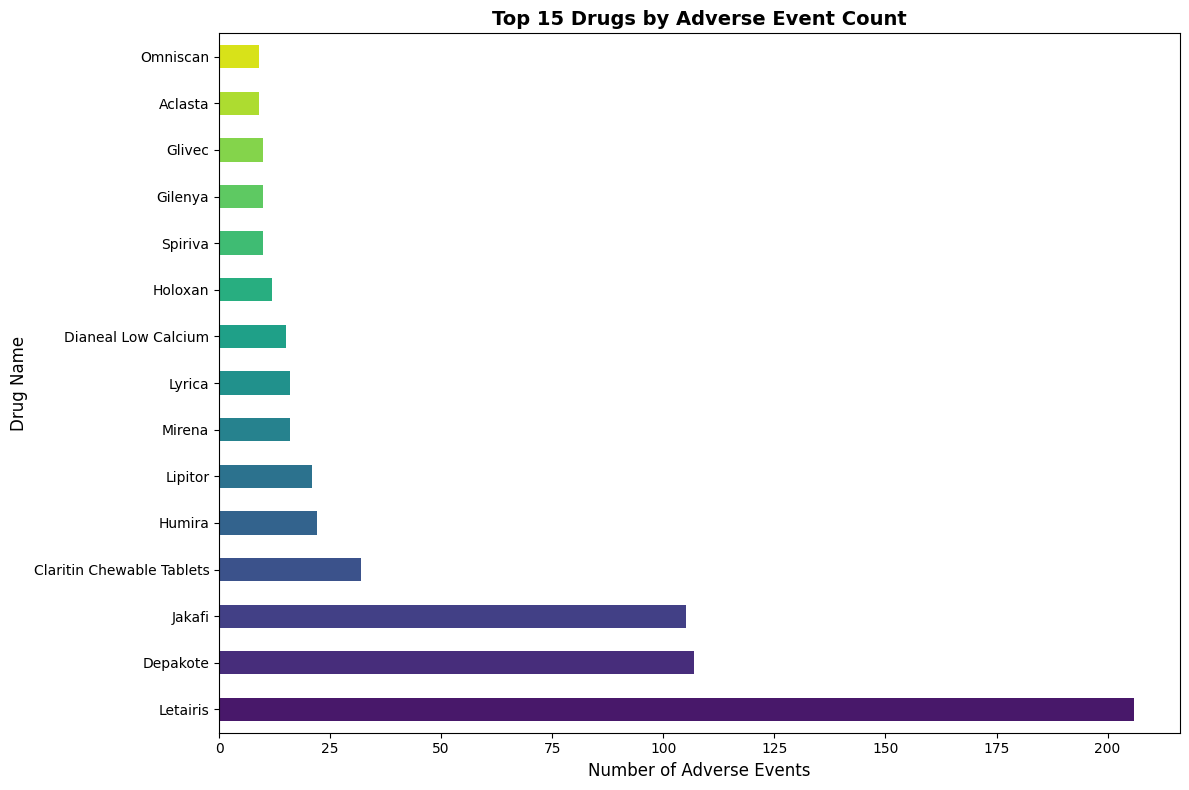


✓ Saved: top_drugs_by_events.png


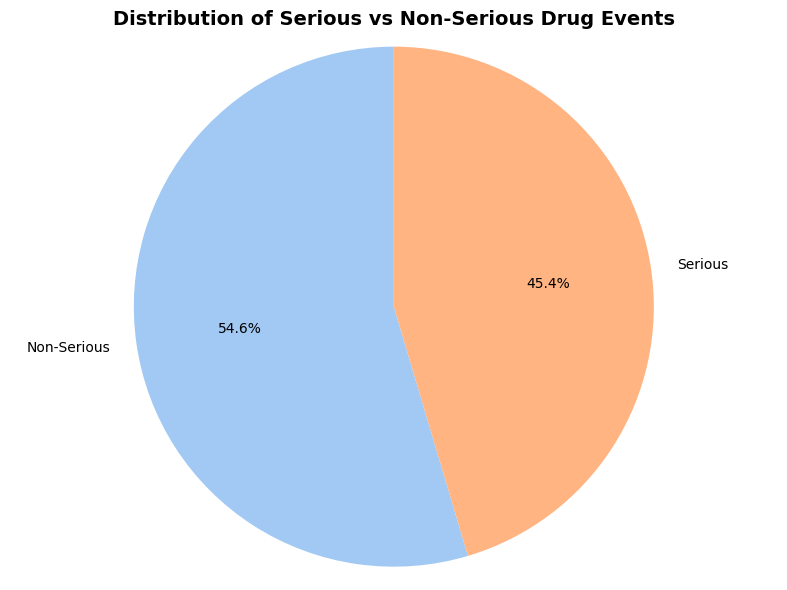


✓ Saved: drug_serious_events_distribution.png


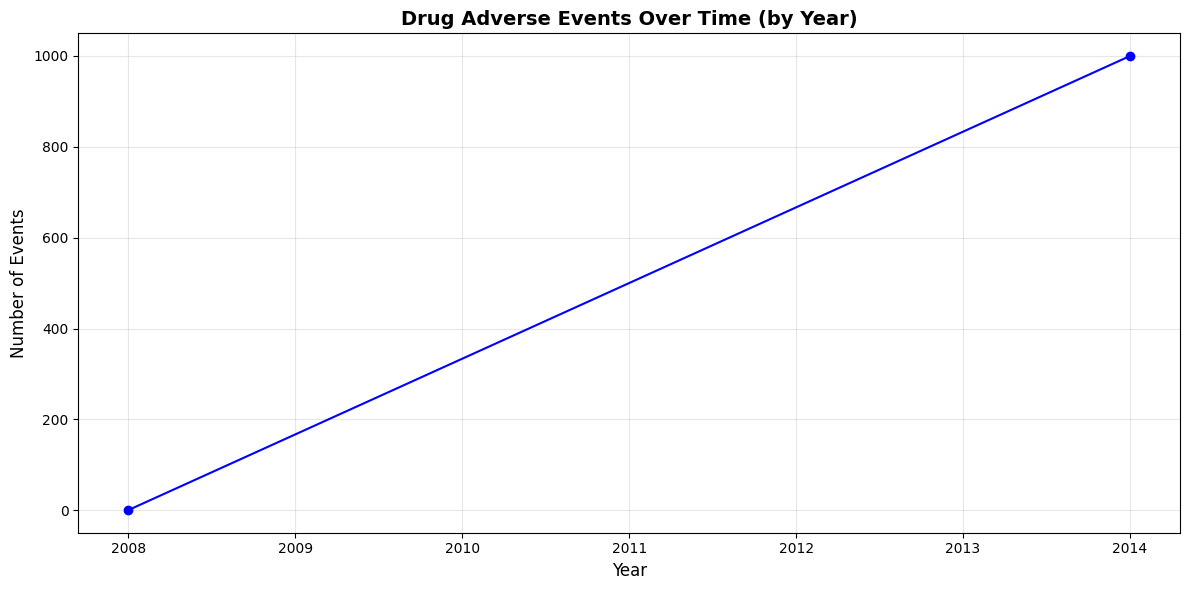


✓ Saved: drug_events_over_time_yearly.png


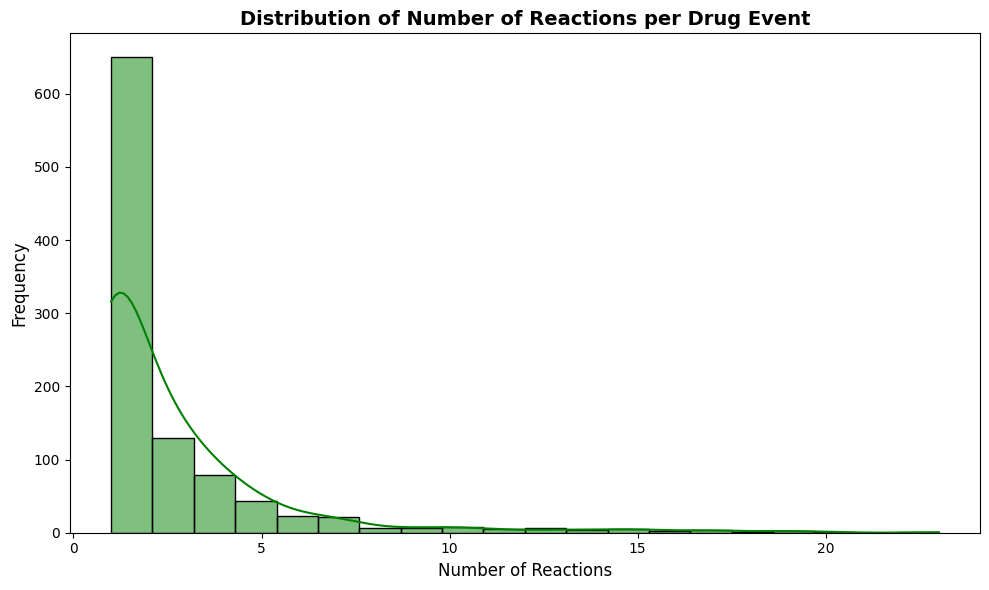


✓ Saved: drug_reaction_count_distribution.png

No meaningful device name data available for plotting.


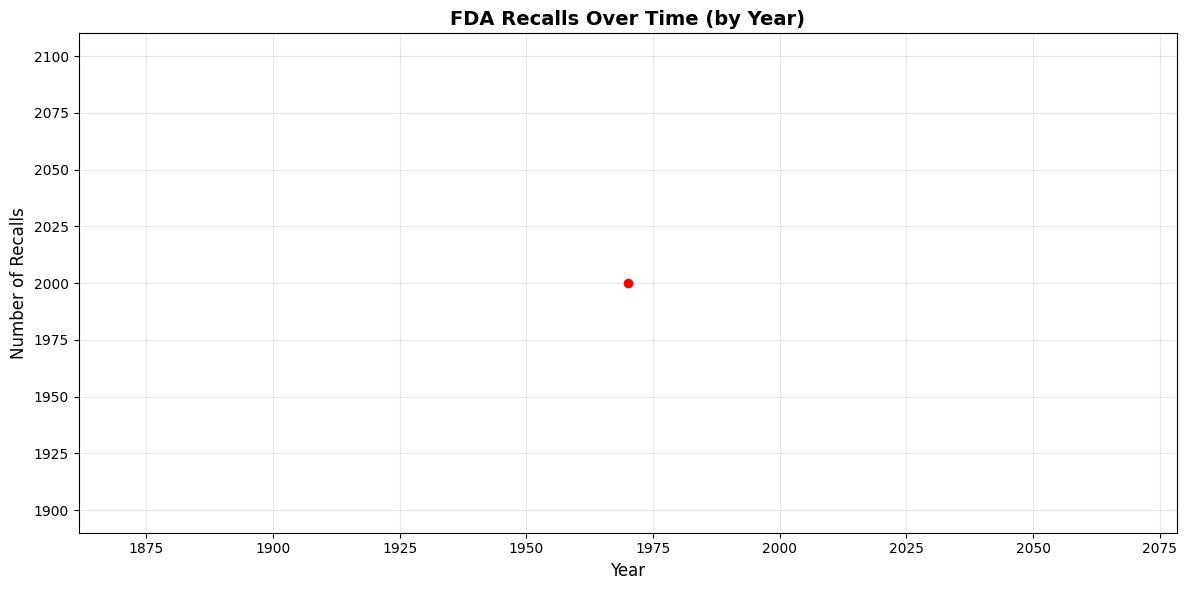


✓ Saved: recalls_over_time_yearly.png


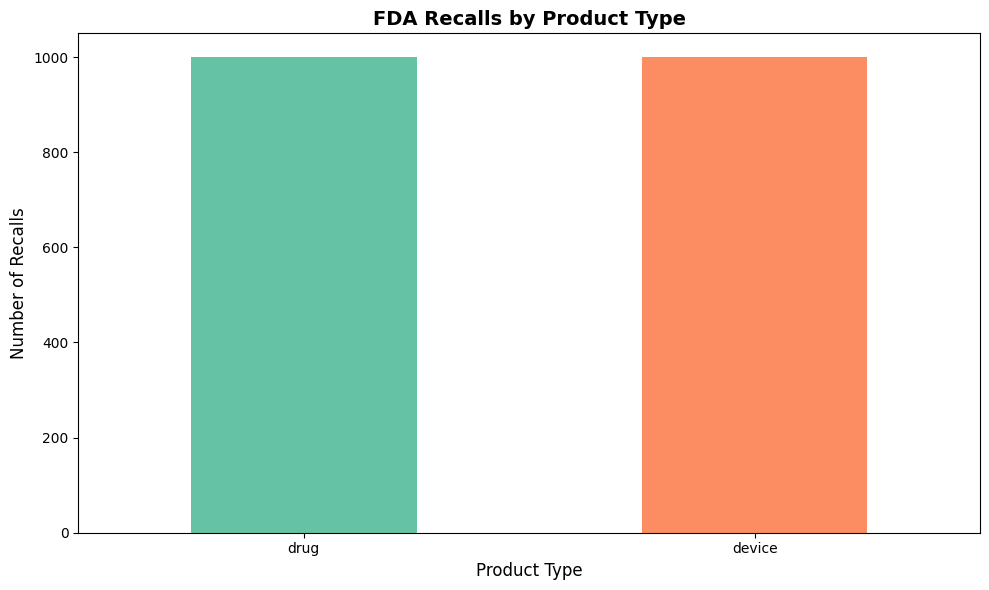


✓ Saved: recalls_by_product_type_bar.png

✓ All plots saved to: /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_recalls_analysis_plots


In [73]:
# Create output directory for plots
plot_dir = BASE_DIR / "adverse_events_recalls_analysis_plots"
plot_dir.mkdir(exist_ok=True)

In [ ]:
# Drug adverse events - Top drugs
if drug_ae_cleaned is not None and 'drug_product_name_cleaned' in drug_ae_cleaned.columns:
    top_drugs = drug_ae_cleaned['drug_product_name_cleaned'].dropna().value_counts().head(15)

    if len(top_drugs) > 0:
        plt.figure(figsize=(12, 8))
        top_drugs.plot(kind='barh', color=sns.color_palette('viridis', len(top_drugs)))
        plt.title('Top 15 Drugs by Adverse Event Count', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Adverse Events', fontsize=12)
        plt.ylabel('Drug Name', fontsize=12)
        plt.tight_layout()
        plt.savefig(plot_dir / 'top_drugs_by_events.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: top_drugs_by_events.png")

In [ ]:

# Serious vs non-serious events
if drug_ae_cleaned is not None and 'serious_binary' in drug_ae_cleaned.columns:
    serious_counts = drug_ae_cleaned['serious_binary'].value_counts()

    if len(serious_counts) > 0:
        plt.figure(figsize=(8, 6))
        labels = ['Non-Serious', 'Serious'] if len(serious_counts) == 2 else serious_counts.index
        colors = sns.color_palette('pastel')[0:len(serious_counts)]
        plt.pie(serious_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Distribution of Serious vs Non-Serious Drug Events', fontsize=14, fontweight='bold')
        plt.ylabel('')
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.tight_layout()
        plt.savefig(plot_dir / 'drug_serious_events_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: drug_serious_events_distribution.png")

In [ ]:
# Events over time
if drug_ae_cleaned is not None and 'year' in drug_ae_cleaned.columns:
    events_by_year = drug_ae_cleaned['year'].dropna().value_counts().sort_index()

    if len(events_by_year) > 0:
        plt.figure(figsize=(12, 6))
        events_by_year.plot(kind='line', marker='o', color='blue')
        plt.title('Drug Adverse Events Over Time (by Year)', fontsize=14, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Number of Events', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(plot_dir / 'drug_events_over_time_yearly.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: drug_events_over_time_yearly.png")

In [ ]:

# Reaction count distribution
if drug_ae_cleaned is not None and 'reaction_count' in drug_ae_cleaned.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(drug_ae_cleaned['reaction_count'], bins=20, kde=True, color='green')
    plt.title('Distribution of Number of Reactions per Drug Event', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Reactions', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.savefig(plot_dir / 'drug_reaction_count_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Saved: drug_reaction_count_distribution.png")

In [ ]:
# Top devices by events
if device_ae_cleaned is not None and 'device_name_cleaned' in device_ae_cleaned.columns:
    top_devices = device_ae_cleaned['device_name_cleaned'].dropna().value_counts().head(15)

    if len(top_devices) > 0 and top_devices.index[0] != 'Nan': # Check if there are meaningful device names
        plt.figure(figsize=(12, 8))
        top_devices.plot(kind='barh', color=sns.color_palette('plasma', len(top_devices)))
        plt.title('Top 15 Medical Devices by Adverse Event Count', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Adverse Events', fontsize=12)
        plt.ylabel('Device Name', fontsize=12)
        plt.gca().invert_yaxis() # Show highest count at the top
        plt.tight_layout()
        plt.savefig(plot_dir / 'top_devices_by_events.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: top_devices_by_events.png")
    else:
        print("\nNo meaningful device name data available for plotting.")

In [ ]:


# Recalls over time
if recalls_cleaned is not None and 'year' in recalls_cleaned.columns:
    recalls_by_year = recalls_cleaned['year'].dropna().value_counts().sort_index()

    if len(recalls_by_year) > 0:
        plt.figure(figsize=(12, 6))
        recalls_by_year.plot(kind='line', marker='o', color='red')
        plt.title('FDA Recalls Over Time (by Year)', fontsize=14, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Number of Recalls', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(plot_dir / 'recalls_over_time_yearly.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: recalls_over_time_yearly.png")

In [ ]:
# Product types in recalls
if recalls_cleaned is not None and 'product_type' in recalls_cleaned.columns:
    product_types = recalls_cleaned['product_type'].value_counts() # Plot all, not just top 10

    if len(product_types) > 0:
        plt.figure(figsize=(10, 6))
        product_types.plot(kind='bar', color=sns.color_palette('Set2', len(product_types)))
        plt.title('FDA Recalls by Product Type', fontsize=14, fontweight='bold')
        plt.xlabel('Product Type', fontsize=12)
        plt.ylabel('Number of Recalls', fontsize=12)
        plt.xticks(rotation=0) # Keep labels horizontal for few categories
        plt.tight_layout()
        plt.savefig(plot_dir / 'recalls_by_product_type_bar.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: recalls_by_product_type_bar.png")

print(f"\n✓ All plots saved to: {plot_dir}")

## Analyzing Trends in Recalls Data

ANALYZING RECALLS DATA TRENDS
RECALLS OVER TIME (MONTHLY)
Monthly Recall Counts:
year_month
2005-12    1
2006-12    1
2009-01    1
2010-07    1
2011-01    2
          ..
2025-05    6
2025-06    8
2025-07    7
2025-08    9
2025-09    5
Freq: M, Name: count, Length: 172, dtype: int64


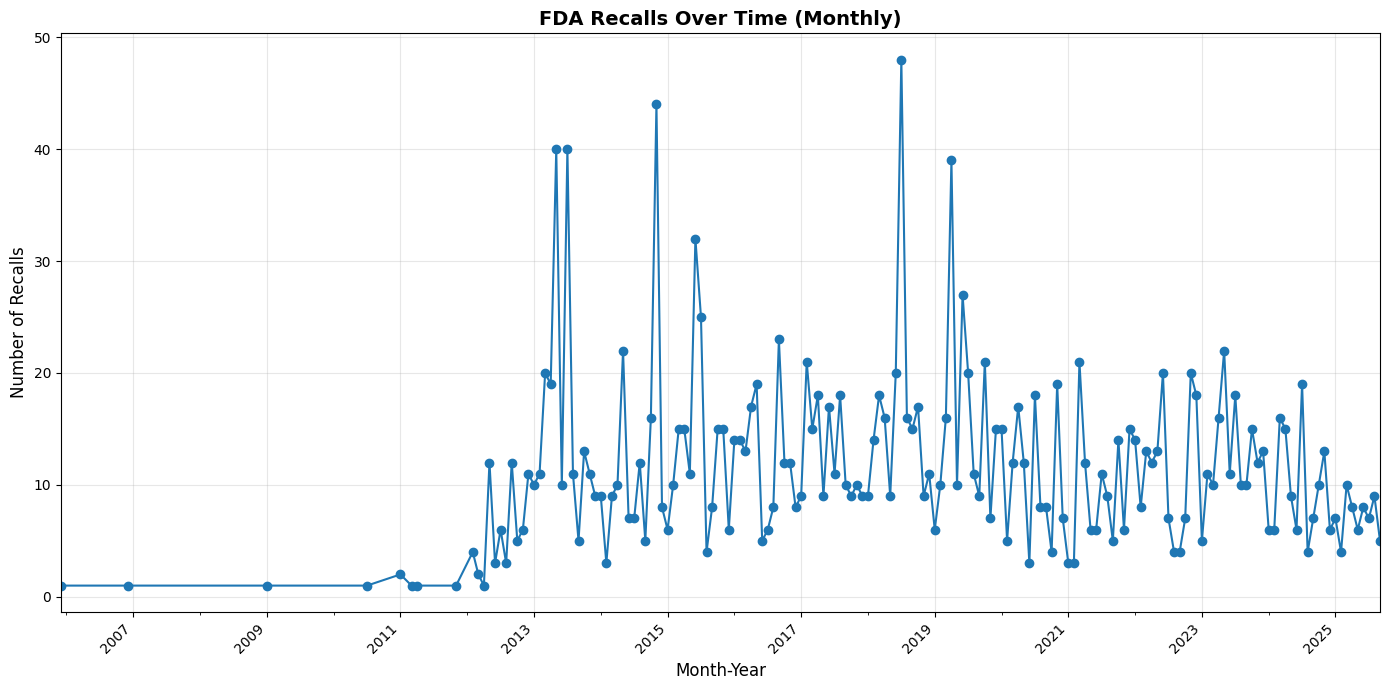


✓ Saved: recalls_over_time_monthly.png
RECALLS BY PRODUCT TYPE
product_type
drug      1000
device    1000
Name: count, dtype: int64


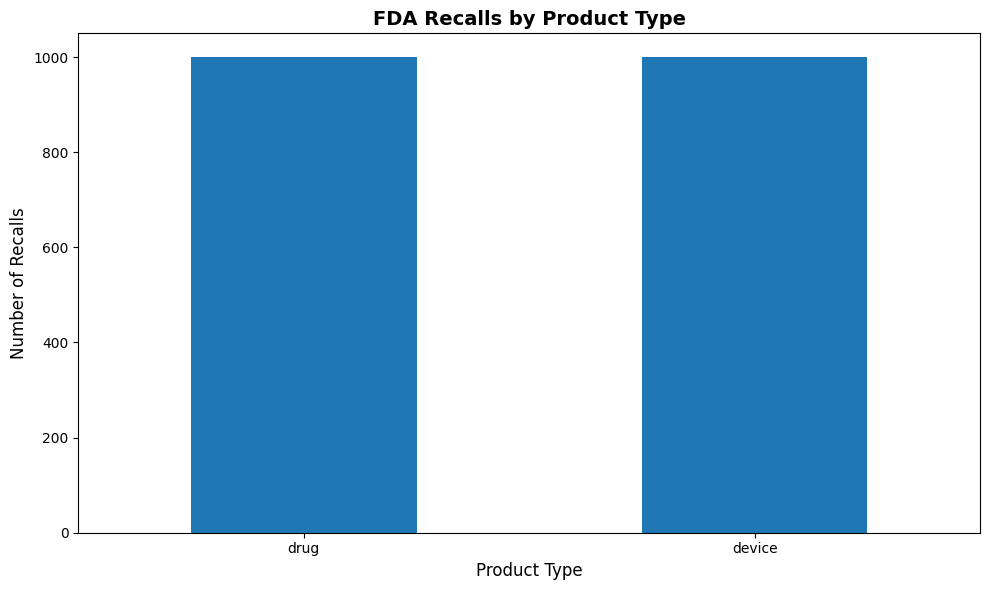


✓ Saved: recalls_by_product_type_bar.png
TOP RECALL REASONS
Top 20 Most Common Recall Reasons:
reason_for_recall
Lack of Assurance of Sterility                                                                                                                                                                                                                                                                                                                     108
Microbial contamination                                                                                                                                                                                                                                                                                                                             30
Penicillin Cross Contamination: All lots of all products repackaged and distributed between 01/05/12 and 02/12/15 are being recalled because they were repackaged in a facility with penicillin products

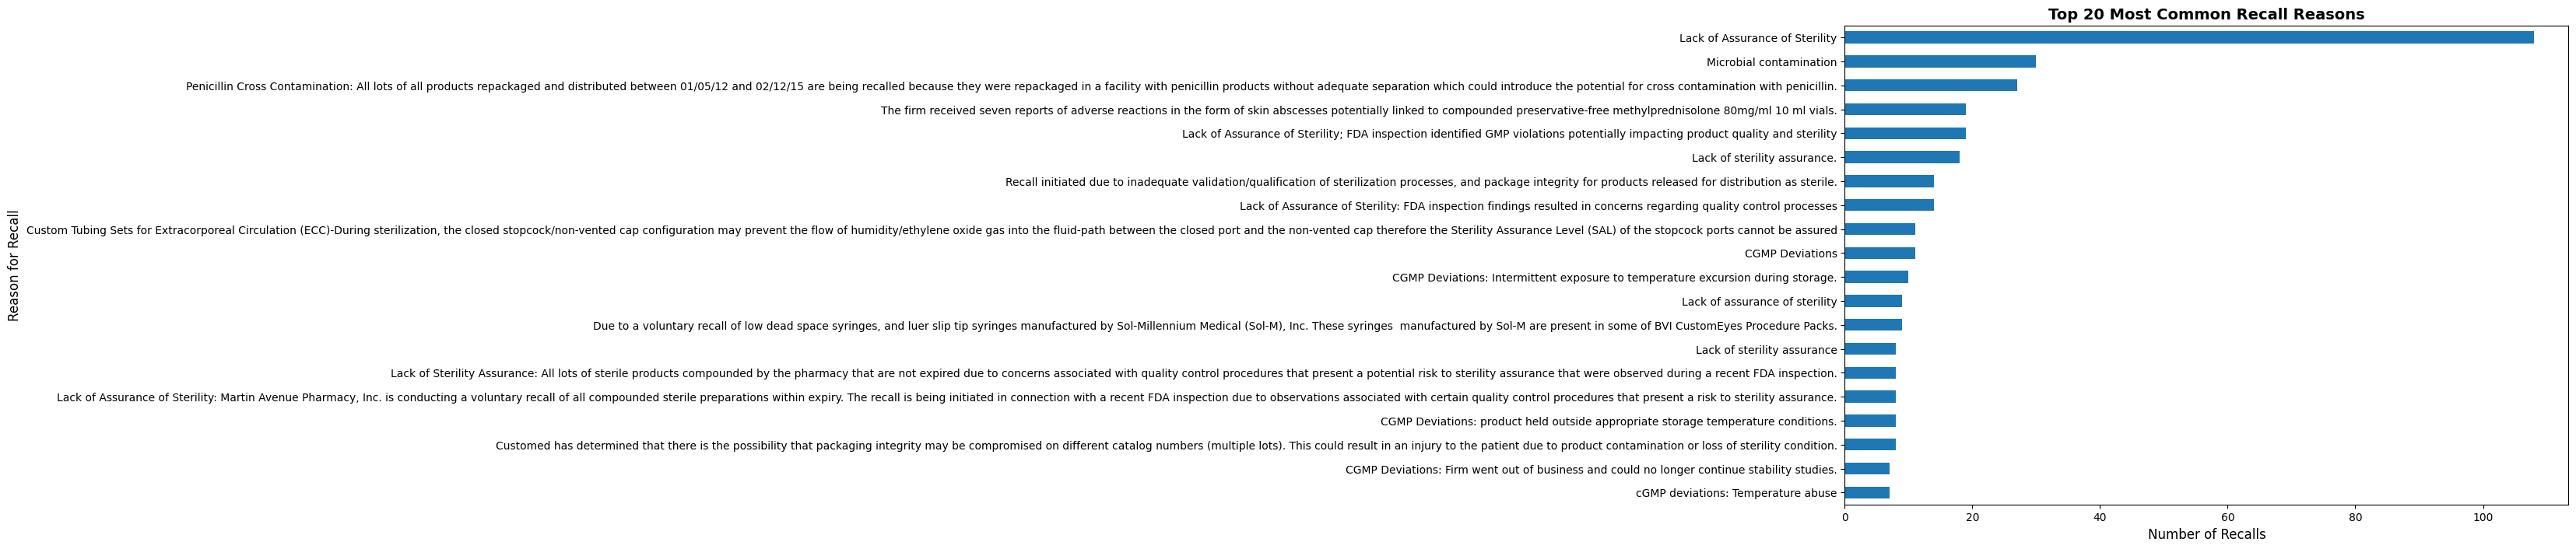


✓ Saved: top_recall_reasons.png


In [74]:
# Analyze Recalls Trends

if recalls_cleaned is not None and len(recalls_cleaned) > 0:
    print("ANALYZING RECALLS DATA TRENDS")

    # 1. Recalls over time (Monthly)
    if 'recall_initiation_date_parsed' in recalls_cleaned.columns:
        print("RECALLS OVER TIME (MONTHLY)")
        # Create a Year-Month column for grouping
        recalls_cleaned['year_month'] = recalls_cleaned['recall_initiation_date_parsed'].dt.to_period('M')
        recalls_by_month = recalls_cleaned['year_month'].value_counts().sort_index()

        if len(recalls_by_month) > 0:
            print("Monthly Recall Counts:")
            print(recalls_by_month)

            # Visualize monthly trends
            plt.figure(figsize=(14, 7))
            recalls_by_month.plot(kind='line', marker='o')
            plt.title('FDA Recalls Over Time (Monthly)', fontsize=14, fontweight='bold')
            plt.xlabel('Month-Year', fontsize=12)
            plt.ylabel('Number of Recalls', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(plot_dir / 'recalls_over_time_monthly.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("\n✓ Saved: recalls_over_time_monthly.png")
        else:
            print("No valid dates to analyze monthly trends.")


    # 2. Recalls by Product Type (already seen in exploration, but can re-display)
    if 'product_type' in recalls_cleaned.columns:
        print("RECALLS BY PRODUCT TYPE")
        product_types_counts = recalls_cleaned['product_type'].value_counts()
        print(product_types_counts)

        if len(product_types_counts) > 0:
             # Visualize product types
            plt.figure(figsize=(10, 6))
            product_types_counts.plot(kind='bar')
            plt.title('FDA Recalls by Product Type', fontsize=14, fontweight='bold')
            plt.xlabel('Product Type', fontsize=12)
            plt.ylabel('Number of Recalls', fontsize=12)
            plt.xticks(rotation=0) # Keep labels horizontal for few categories
            plt.tight_layout()
            plt.savefig(plot_dir / 'recalls_by_product_type_bar.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("\n✓ Saved: recalls_by_product_type_bar.png")


    # 3. Top Recall Reasons
    if 'reason_for_recall' in recalls_cleaned.columns:
        print("TOP RECALL REASONS")
        # Simple count of reason strings (may need more sophisticated text analysis for real trends)
        reason_counts = recalls_cleaned['reason_for_recall'].value_counts().head(20)
        print("Top 20 Most Common Recall Reasons:")
        print(reason_counts)

        if len(reason_counts) > 0:
            plt.figure(figsize=(12, 8))
            reason_counts.plot(kind='barh')
            plt.title('Top 20 Most Common Recall Reasons', fontsize=14, fontweight='bold')
            plt.xlabel('Number of Recalls', fontsize=12)
            plt.ylabel('Reason for Recall', fontsize=12)
            plt.gca().invert_yaxis() # Show highest count at the top
            plt.tight_layout()
            plt.savefig(plot_dir / 'top_recall_reasons.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("\n✓ Saved: top_recall_reasons.png")


else:
    print("\nRecalls data not available for trend analysis.")

In [75]:
# Save Cleaned Data for next steps
print("SAVING CLEANED DATA")

# Save cleaned drug adverse events
if drug_ae_cleaned is not None:
    output_path_parquet = OUTPUT_DIR / "drug_adverse_events_cleaned.parquet"
    output_path_csv = OUTPUT_DIR / "drug_adverse_events_cleaned.csv"

    drug_ae_cleaned.to_parquet(output_path_parquet, index=False)
    drug_ae_cleaned.to_csv(output_path_csv, index=False)

    print(f"\n✓ Saved cleaned drug adverse events:")
    print(f"  Parquet: {output_path_parquet}")
    print(f"  CSV: {output_path_csv}")
    print(f"  Records: {len(drug_ae_cleaned):,}")

# Save cleaned device adverse events
if device_ae_cleaned is not None:
    output_path_parquet = OUTPUT_DIR / "device_adverse_events_cleaned.parquet"
    output_path_csv = OUTPUT_DIR / "device_adverse_events_cleaned.csv"

    device_ae_cleaned.to_parquet(output_path_parquet, index=False)
    device_ae_cleaned.to_csv(output_path_csv, index=False)

    print(f"\n✓ Saved cleaned device adverse events:")
    print(f"  Parquet: {output_path_parquet}")
    print(f"  CSV: {output_path_csv}")
    print(f"  Records: {len(device_ae_cleaned):,}")

# Save cleaned biologics
if biologics_ae_df is not None and len(biologics_ae_df) > 0:
    output_path_parquet = OUTPUT_DIR / "biologics_adverse_events_cleaned.parquet"
    output_path_csv = OUTPUT_DIR / "biologics_adverse_events_cleaned.csv"

    biologics_ae_df.to_parquet(output_path_parquet, index=False)
    biologics_ae_df.to_csv(output_path_csv, index=False)

    print(f"\n✓ Saved biologics adverse events:")
    print(f"  Parquet: {output_path_parquet}")
    print(f"  CSV: {output_path_csv}")
    print(f"  Records: {len(biologics_ae_df):,}")

# Save cleaned recalls
if recalls_cleaned is not None:
    output_path_parquet = OUTPUT_DIR / "recalls_cleaned.parquet"
    output_path_csv = OUTPUT_DIR / "recalls_cleaned.csv"

    recalls_cleaned.to_parquet(output_path_parquet, index=False)
    recalls_cleaned.to_csv(output_path_csv, index=False)

    print(f"\n✓ Saved cleaned recalls:")
    print(f"  Parquet: {output_path_parquet}")
    print(f"  CSV: {output_path_csv}")
    print(f"  Records: {len(recalls_cleaned):,}")

print("Data cleaning and exploration complete!")

SAVING CLEANED DATA

✓ Saved cleaned drug adverse events:
  Parquet: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/adverse_events_recalls_cleaned/drug_adverse_events_cleaned.parquet
  CSV: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/adverse_events_recalls_cleaned/drug_adverse_events_cleaned.csv
  Records: 1,000

✓ Saved cleaned device adverse events:
  Parquet: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/adverse_events_recalls_cleaned/device_adverse_events_cleaned.parquet
  CSV: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/adverse_events_recalls_cleaned/device_adverse_events_cleaned.csv
  Records: 1,000

✓ Saved biologics adverse events:
  Parquet: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/adverse_events_recalls_cleaned/biologics_adverse_events_cleaned.parquet
  CSV: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls

## Medical device exploration


**Reasoning**:
Perform detailed exploration of the device_ae_cleaned DataFrame, including basic info, missing values, sample records, device names, event types, and device problems, similar to the drug exploration.



In [76]:
# Device Adverse Events - Detailed Exploration
if device_ae_cleaned is not None and len(device_ae_cleaned) > 0:
    print("DEVICE ADVERSE EVENTS - DETAILED EXPLORATION")

    # Basic exploration
    print(f"\nDataset Shape: {device_ae_cleaned.shape}")
    print(f"Memory Usage: {device_ae_cleaned.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Column info
    print("COLUMN INFORMATION:")
    print(device_ae_cleaned.info())

    # Missing values
    print("MISSING VALUES:")
    missing = device_ae_cleaned.isnull().sum()
    missing_pct = (missing / len(device_ae_cleaned)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("No missing values!")

    # Sample records
    print("SAMPLE RECORDS (First 5):")
    display(device_ae_cleaned.head())

    # Device names analysis
    if 'device_name_cleaned' in device_ae_cleaned.columns:
        print("DEVICE NAMES:")
        non_empty = device_ae_cleaned['device_name_cleaned'].notna() & (device_ae_cleaned['device_name_cleaned'].astype(str).str.strip() != '')
        print(f"Records with device names: {non_empty.sum():,} ({non_empty.sum()/len(device_ae_cleaned)*100:.1f}%)")
        if non_empty.sum() > 0:
            print(f"Unique devices: {device_ae_cleaned[device_ae_cleaned['device_name_cleaned'].notna()]['device_name_cleaned'].nunique():,}")
            print("\nTop 20 Devices by Adverse Event Count:")
            print(device_ae_cleaned['device_name_cleaned'].value_counts().head(20))

    # Event types
    if 'event_type' in device_ae_cleaned.columns:
        print("EVENT TYPES:")
        print(device_ae_cleaned['event_type'].value_counts())

    # Device problems
    if 'device_problem' in device_ae_cleaned.columns:
        print("DEVICE PROBLEMS:")
        non_empty = device_ae_cleaned['device_problem'].notna() & (device_ae_cleaned['device_problem'].astype(str).str.strip() != '')
        if non_empty.sum() > 0:
            print(device_ae_cleaned['device_problem'].value_counts().head(20))
        else:
            print("No device problem information available.")

else:
    print("\nNo device adverse events data available for detailed exploration")

DEVICE ADVERSE EVENTS - DETAILED EXPLORATION

Dataset Shape: (1000, 12)
Memory Usage: 8.47 MB
COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_key             0 non-null      float64
 1   report_date           1000 non-null   int64  
 2   device_name           1000 non-null   object 
 3   device_product_code   0 non-null      float64
 4   manufacturer          1000 non-null   object 
 5   event_type            1000 non-null   object 
 6   adverse_event_flag    981 non-null    object 
 7   product_problem_flag  994 non-null    object 
 8   device_problem        0 non-null      float64
 9   mdr_text              1000 non-null   object 
 10  raw_data              1000 non-null   object 
 11  device_name_cleaned   1000 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 93.9+ KB
Non

,event_key,report_date,device_name,device_product_code,manufacturer,event_type,adverse_event_flag,product_problem_flag,device_problem,mdr_text,raw_data,device_name_cleaned
0,NaN,19920220,nan,NaN,nan,Injury,Y,N,NaN,"[{'mdr_text_key': '3', 'text_type_code': 'Description of Event or Problem', 'patient_sequence_nu...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": ""HOSPITA...",Nan
1,NaN,19920629,nan,NaN,nan,Injury,Y,N,NaN,"[{'mdr_text_key': '614', 'text_type_code': 'Description of Event or Problem', 'patient_sequence_...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": ""OTHER"",...",Nan
2,NaN,19940805,nan,NaN,nan,No answer provided,*,*,NaN,"[{'mdr_text_key': '5377', 'text_type_code': 'Description of Event or Problem', 'patient_sequence...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": ""INVALID...",Nan
3,NaN,19970428,nan,NaN,nan,Injury,N,Y,NaN,"[{'mdr_text_key': '21392769', 'text_type_code': 'Description of Event or Problem', 'patient_sequ...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": ""HOSPITA...",Nan
4,NaN,20071216,nan,NaN,nan,Malfunction,N,Y,NaN,"[{'mdr_text_key': '788224', 'text_type_code': 'Description of Event or Problem', 'patient_sequen...","{""manufacturer_contact_zip_ext"": """", ""manufacturer_g1_address_2"": """", ""event_location"": """", ""rep...",Nan


DEVICE NAMES:
Records with device names: 1,000 (100.0%)
Unique devices: 1

Top 20 Devices by Adverse Event Count:
device_name_cleaned
Nan    1000
Name: count, dtype: int64
EVENT TYPES:
event_type
Malfunction           583
Injury                406
Other                   7
No answer provided      2
Death                   2
Name: count, dtype: int64
DEVICE PROBLEMS:
No device problem information available.


## Medical device analysis


In [77]:
# DEVICE ADVERSE EVENTS - DETAILED ANALYSIS
if device_ae_cleaned is not None and len(device_ae_cleaned) > 0:
    print("DEVICE ADVERSE EVENTS - DETAILED ANALYSIS")

    # 1. Analyze Event Types
    if 'event_type' in device_ae_cleaned.columns:
        print("ANALYSIS BY EVENT TYPE")
        event_type_counts = device_ae_cleaned['event_type'].value_counts()
        print("Event Type Counts:")
        print(event_type_counts)

        event_type_pct = device_ae_cleaned['event_type'].value_counts(normalize=True) * 100
        print("\nEvent Type Percentage:")
        print(event_type_pct)
    else:
        print("\n'event_type' column not found in device_ae_cleaned.")


    # 2. Analyze Device Problems
    if 'device_problem' in device_ae_cleaned.columns:
        print("ANALYSIS BY DEVICE PROBLEMS")
        non_empty_problems = device_ae_cleaned['device_problem'].dropna()
        if len(non_empty_problems) > 0:
            print("Top 10 Most Frequent Device Problems:")
            print(non_empty_problems.value_counts().head(10))
            print("\nNote: Further text processing (e.g., tokenization, stemming, topic modeling) might be needed for more meaningful analysis of 'device_problem'.")
        else:
            print("No non-missing device problem information available.")
    else:
        print("\n'device_problem' column not found in device_ae_cleaned.")


    # 3. Analyze Date Trends
    # Checking if data trends prssent
    if 'report_date' in device_ae_cleaned.columns:
        print("ANALYSIS OF DATE TRENDS")

        # Assuming 'report_date' is in YYYYMMDD integer format based on previous exploration
        device_ae_cleaned['report_date_parsed'] = pd.to_datetime(device_ae_cleaned['report_date'], format='%Y%m%d', errors='coerce')
        valid_dates = device_ae_cleaned['report_date_parsed'].notna()

        if valid_dates.sum() > 0:
            device_ae_cleaned['report_year'] = device_ae_cleaned['report_date_parsed'].dt.year
            events_by_year = device_ae_cleaned['report_year'].value_counts().sort_index()

            print("Device Adverse Events by Year:")
            print(events_by_year)

            # Consider and print any notable trends observed in the yearly counts.
            if len(events_by_year) > 1:
                print("\nNotable Trends:")
                # Calculate percentage change from previous year
                yearly_change = events_by_year.pct_change() * 100
                print("Yearly Percentage Change in Events:")
                print(yearly_change.dropna())

                # Identify years with significant increase/decrease (threshold could be adjusted)
                significant_increase_years = yearly_change[yearly_change > 50].index.tolist()
                significant_decrease_years = yearly_change[yearly_change < -50].index.tolist()

                if significant_increase_years:
                    print(f"- Years with significant increase (>50%): {significant_increase_years}")
                if significant_decrease_years:
                    print(f"- Years with significant decrease (<-50%): {significant_decrease_years}")

            elif len(events_by_year) == 1:
                 print("\nTrend Note: Data available for only one year, trend analysis is not possible.")
            else:
                 print("\nTrend Note: No valid dates found for trend analysis.")

        else:
            print("No valid dates found for trend analysis.")
    else:
        print("\n'report_date' column not found in device_ae_cleaned.")
else:
    print("\nNo device adverse events data available for detailed analysis.")

DEVICE ADVERSE EVENTS - DETAILED ANALYSIS
ANALYSIS BY EVENT TYPE
Event Type Counts:
event_type
Malfunction           583
Injury                406
Other                   7
No answer provided      2
Death                   2
Name: count, dtype: int64

Event Type Percentage:
event_type
Malfunction           58.3
Injury                40.6
Other                  0.7
No answer provided     0.2
Death                  0.2
Name: proportion, dtype: float64
ANALYSIS BY DEVICE PROBLEMS
No non-missing device problem information available.
ANALYSIS OF DATE TRENDS
Device Adverse Events by Year:
report_year
1992      2
1994      1
1997      9
2002      2
2004      2
2005      4
2006      3
2007     21
2008     61
2010      1
2011      4
2012      7
2013      1
2015      1
2016      2
2017     10
2018      2
2019     88
2020    779
Name: count, dtype: int64

Notable Trends:
Yearly Percentage Change in Events:
report_year
1994     -50.000000
1997     800.000000
2002     -77.777778
2004       0.000000

## Biologics Adverse Events - Exploration

In [78]:
# Biologics Adverse Events - Basic Exploration
if biologics_ae_df is not None and len(biologics_ae_df) > 0:
    print("BIOLOGICS ADVERSE EVENTS - BASIC EXPLORATION")

    print(f"\nDataset Shape: {biologics_ae_df.shape}")
    print(f"Memory Usage: {biologics_ae_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Column info
    print("COLUMN INFORMATION:")
    print(biologics_ae_df.info())

    # Missing values
    print("MISSING VALUES:")
    missing = biologics_ae_df.isnull().sum()
    missing_pct = (missing / len(biologics_ae_df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("No missing values!")

    # First few records
    print("SAMPLE RECORDS (First 5):")
    display(biologics_ae_df.head())

    # Basic statistics for numeric columns
    numeric_cols = biologics_ae_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("NUMERIC COLUMNS STATISTICS:")
        print(biologics_ae_df[numeric_cols].describe())
else:
    print("\nNo biologics adverse events data available for exploration")

BIOLOGICS ADVERSE EVENTS - BASIC EXPLORATION

Dataset Shape: (51, 14)
Memory Usage: 2.03 MB
COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   safetyreportid               51 non-null     int64  
 1   receivedate                  51 non-null     int64  
 2   serious                      51 non-null     int64  
 3   biologics_product_name       51 non-null     object 
 4   biologics_generic_name       0 non-null      float64
 5   biologics_brand_name         9 non-null      object 
 6   biologics_product_names_all  51 non-null     object 
 7   biologics_count              51 non-null     int64  
 8   adverse_reactions            51 non-null     object 
 9   reaction_count               51 non-null     int64  
 10  patient_age                  37 non-null     float64
 11  patient_sex               

,safetyreportid,receivedate,serious,biologics_product_name,biologics_generic_name,biologics_brand_name,biologics_product_names_all,biologics_count,adverse_reactions,reaction_count,patient_age,patient_sex,category,raw_data
0,10003329,20140312,1,INSULINA GLARGINE,NaN,NaN,"INSULINA GLARGINE, INSULINA GLULISINA",2,"Diarrhoea, Abdominal pain, Asthenia, Diarrhoea, Weight decreased, Abdominal pain, Blood creatini...",13,79.0,2.0,Biologics,"{""safetyreportversion"": ""11"", ""safetyreportid"": ""10003329"", ""primarysourcecountry"": ""IT"", ""occur..."
1,10003554,20140312,1,INTERFERON BETA-1A,NaN,REBIF,INTERFERON BETA-1A,1,"Monocyte count decreased, Gamma-glutamyltransferase increased, B-lymphocyte count decreased, Ski...",10,38.0,1.0,Biologics,"{""safetyreportversion"": ""9"", ""safetyreportid"": ""10003554"", ""primarysourcecountry"": ""GB"", ""occurc..."
2,10003633,20140312,1,INTRAVENOUS IMMUNOGLOBULIN,NaN,NaN,INTRAVENOUS IMMUNOGLOBULIN,1,Nephrogenic systemic fibrosis,1,70.0,1.0,Biologics,"{""safetyreportversion"": ""2"", ""safetyreportid"": ""10003633"", ""primarysourcecountry"": ""US"", ""occurc..."
3,10003642,20140312,1,VITAMIN E,NaN,STYE EYE RELIEF SERUM,VITAMIN E,1,Osteomyelitis,1,66.0,2.0,Biologics,"{""safetyreportversion"": ""1"", ""safetyreportid"": ""10003642"", ""primarysourcecountry"": ""US"", ""occurc..."
4,10004037,20140312,2,PEGINTERFERON ALFA-2B,NaN,NaN,PEGINTERFERON ALFA-2B,1,"Chills, Myalgia, Headache, Dizziness, Nausea, Myalgia, Chills",7,52.0,2.0,Biologics,"{""safetyreportversion"": ""2"", ""safetyreportid"": ""10004037"", ""primarysourcecountry"": ""PR"", ""occurc..."


NUMERIC COLUMNS STATISTICS:
       safetyreportid   receivedate    serious  biologics_generic_name  \
count    5.100000e+01  5.100000e+01  51.000000                     0.0   
mean     1.000604e+07  2.014031e+07   1.117647                     NaN   
std      1.375650e+03  1.185352e+01   0.325396                     NaN   
min      1.000333e+07  2.014023e+07   1.000000                     NaN   
25%      1.000495e+07  2.014031e+07   1.000000                     NaN   
50%      1.000626e+07  2.014031e+07   1.000000                     NaN   
75%      1.000716e+07  2.014031e+07   1.000000                     NaN   
max      1.000815e+07  2.014031e+07   2.000000                     NaN   

       biologics_count  reaction_count  patient_age  patient_sex  
count        51.000000       51.000000    37.000000    50.000000  
mean          1.196078        3.627451    63.027027     1.440000  
std           0.566378        3.709236    16.483134     0.674915  
min           1.000000        1.00000

**Reasoning**:
Continue the exploration of the biologics adverse events data by analyzing key columns like product names, adverse reactions, serious events, and patient demographics, similar to the drug data detailed analysis.



In [79]:
# Biologics Adverse Events - Detailed Analysis
if biologics_ae_df is not None and len(biologics_ae_df) > 0:
    print("BIOLOGICS ADVERSE EVENTS - DETAILED ANALYSIS")

    # Biologics product names analysis
    if 'biologics_product_name' in biologics_ae_df.columns:
        print("BIOLOGICS PRODUCT NAMES:")
        non_empty = biologics_ae_df['biologics_product_name'].notna() & (biologics_ae_df['biologics_product_name'].astype(str).str.strip() != '')
        print(f"Records with product names: {non_empty.sum():,} ({non_empty.sum()/len(biologics_ae_df)*100:.1f}%)")
        if non_empty.sum() > 0:
            print(f"Unique biologics products: {biologics_ae_df[biologics_ae_df['biologics_product_name'].notna()]['biologics_product_name'].nunique():,}")
            print("\nTop 20 Biologics Products by Adverse Event Count:")
            print(biologics_ae_df['biologics_product_name'].value_counts().head(20))

    # Generic names
    if 'biologics_generic_name' in biologics_ae_df.columns:
        print("GENERIC NAMES:")
        non_empty = biologics_ae_df['biologics_generic_name'].notna() & (biologics_ae_df['biologics_generic_name'].astype(str).str.strip() != '')
        print(f"Records with generic names: {non_empty.sum():,} ({non_empty.sum()/len(biologics_ae_df)*100:.1f}%)")
        if non_empty.sum() > 0:
            print(f"Unique generic names: {biologics_ae_df[biologics_ae_df['biologics_generic_name'].notna()]['biologics_generic_name'].nunique():,}")
        else:
            print("No generic names found.")

    # Serious events
    if 'serious' in biologics_ae_df.columns:
        print("SERIOUS EVENTS:")
        print(biologics_ae_df['serious'].value_counts())
        serious_count = (biologics_ae_df['serious'] == 1).sum() if 'serious' in biologics_ae_df.columns else 0
        print(f"\nSerious event rate (Serious=1): {serious_count / len(biologics_ae_df) * 100:.2f}%")

    # Adverse reactions
    if 'adverse_reactions' in biologics_ae_df.columns:
        print("ADVERSE REACTIONS:")
        non_empty = biologics_ae_df['adverse_reactions'].notna() & (biologics_ae_df['adverse_reactions'].astype(str).str.strip() != '')
        print(f"Records with reactions: {non_empty.sum():,} ({non_empty.sum()/len(biologics_ae_df)*100:.1f}%)")

        # Extract unique reactions
        all_reactions = []
        for reactions_str in biologics_ae_df[biologics_ae_df['adverse_reactions'].notna()]['adverse_reactions']:
            if reactions_str and str(reactions_str) != 'nan':
                reactions_list = [r.strip() for r in str(reactions_str).split(',')]
                all_reactions.extend([r for r in reactions_list if r])

        if all_reactions:
            reaction_counts = Counter(all_reactions)
            print(f"\nUnique reaction types: {len(reaction_counts):,}")
            print("\nTop 20 Most Common Adverse Reactions:")
            for reaction, count in reaction_counts.most_common(20):
                print(f"  {reaction}: {count:,}")
        else:
            print("No adverse reactions found.")


    # Reaction count
    if 'reaction_count' in biologics_ae_df.columns:
        print("REACTION COUNT PER EVENT:")
        print(biologics_ae_df['reaction_count'].describe())

    # Date analysis
    if 'receivedate' in biologics_ae_df.columns:
        print("DATE ANALYSIS:")
        # Correctly parse integer date format YYYYMMDD
        biologics_ae_df['receivedate_parsed'] = pd.to_datetime(biologics_ae_df['receivedate'], format='%Y%m%d', errors='coerce')
        valid_dates = biologics_ae_df['receivedate_parsed'].notna()
        print(f"Records with valid dates: {valid_dates.sum():,} ({valid_dates.sum()/len(biologics_ae_df)*100:.1f}%)")
        if valid_dates.sum() > 0:
            print(f"Date range: {biologics_ae_df['receivedate_parsed'].min()} to {biologics_ae_df['receivedate_parsed'].max()}")
            print("\nEvents by Year:")
            print(biologics_ae_df['receivedate_parsed'].dt.year.value_counts().sort_index())
        else:
            print("No valid dates found.")

    # Patient demographics
    if 'patient_age' in biologics_ae_df.columns:
        print("PATIENT AGE:")
        numeric_age = pd.to_numeric(biologics_ae_df['patient_age'], errors='coerce')
        valid_age = numeric_age.notna()
        print(f"Records with valid age: {valid_age.sum():,} ({valid_age.sum()/len(biologics_ae_df)*100:.1f}%)")
        if valid_age.sum() > 0:
            print(numeric_age.describe())
        else:
            print("No valid patient age found.")


    if 'patient_sex' in biologics_ae_df.columns:
        print("PATIENT SEX:")
        print(biologics_ae_df['patient_sex'].value_counts(dropna=False)) # Include NaN counts
else:
    print("\nNo biologics adverse events data available for detailed analysis")

BIOLOGICS ADVERSE EVENTS - DETAILED ANALYSIS
BIOLOGICS PRODUCT NAMES:
Records with product names: 51 (100.0%)
Unique biologics products: 29

Top 20 Biologics Products by Adverse Event Count:
biologics_product_name
INSULIN                                   9
VITAMIN E                                 4
COENZYME Q10                              3
BLOOD PRESSURE MEDICATION                 3
INFLIXIMAB, RECOMBINANT                   3
PEGINTERFERON ALFA-2A                     3
INTRAVENOUS IMMUNOGLOBULIN                2
IMMUNOGLOBULINS                           2
INFLUENZA VACCINE                         2
REGULAR INSULIN                           1
INSULINA GLARGINE                         1
INSULIN (INSULIN) (PUMP) (INSULIN)        1
NOVOLIN 30R (INSULIN)                     1
UNSPECIFIED BLOOD PRESSURE MEDICATIONS    1
TETANUS (TETANUS VACCINE)                 1
COENZYME Q-GEL                            1
INSULIN GLARGINE (LANTUS)                 1
RED BLOOD CELLS                       

## Biologics Adverse Events - Data Cleaning

In [80]:
if biologics_ae_df is not None and len(biologics_ae_df) > 0:
    print("BIOLOGICS ADVERSE EVENTS - DATA CLEANING")

    # Create a copy for cleaning
    biologics_ae_clean = biologics_ae_df.copy()
    original_count = len(biologics_ae_clean)

    print(f"\nOriginal record count: {original_count:,}")

    # 1. Clean product names
    if 'biologics_product_name' in biologics_ae_clean.columns:
        print("\n1. Cleaning biologics product names")
        biologics_ae_clean['biologics_product_name'] = biologics_ae_clean['biologics_product_name'].astype(str).str.strip()
        biologics_ae_clean['biologics_product_name'] = biologics_ae_clean['biologics_product_name'].replace('', np.nan)
        biologics_ae_clean['biologics_product_name_cleaned'] = biologics_ae_clean['biologics_product_name'].fillna('').str.title()
        biologics_ae_clean['biologics_product_name_cleaned'] = biologics_ae_clean['biologics_product_name_cleaned'].replace('', np.nan)
        print(f"   Before: {biologics_ae_df['biologics_product_name'].notna().sum():,} non-null")
        print(f"   After: {biologics_ae_clean['biologics_product_name'].notna().sum():,} non-null")

    # 2. Clean brand names
    if 'biologics_brand_name' in biologics_ae_clean.columns:
        print("\n2. Cleaning brand names")
        biologics_ae_clean['biologics_brand_name'] = biologics_ae_clean['biologics_brand_name'].astype(str).str.strip()
        biologics_ae_clean['biologics_brand_name'] = biologics_ae_clean['biologics_brand_name'].replace('', np.nan)
        biologics_ae_clean['biologics_brand_name_cleaned'] = biologics_ae_clean['biologics_brand_name'].fillna('').str.title()
        biologics_ae_clean['biologics_brand_name_cleaned'] = biologics_ae_clean['biologics_brand_name_cleaned'].replace('', np.nan)


    # 3. Clean adverse reactions
    if 'adverse_reactions' in biologics_ae_clean.columns:
        print("\n3. Cleaning adverse reactions...")
        biologics_ae_clean['adverse_reactions'] = biologics_ae_clean['adverse_reactions'].astype(str)
        biologics_ae_clean['adverse_reactions'] = biologics_ae_clean['adverse_reactions'].str.replace(',', ', ')
        biologics_ae_clean['adverse_reactions'] = biologics_ae_clean['adverse_reactions'].str.replace(r'\s+', ' ', regex=True)
        biologics_ae_clean['adverse_reactions'] = biologics_ae_clean['adverse_reactions'].str.strip()
        biologics_ae_clean['adverse_reactions'] = biologics_ae_clean['adverse_reactions'].replace('', np.nan)
        biologics_ae_clean['adverse_reactions'] = biologics_ae_clean['adverse_reactions'].replace('nan', np.nan)


    # 4. Clean dates
    if 'receivedate' in biologics_ae_clean.columns:
        print("\n4. Cleaning dates")
        biologics_ae_clean['receivedate_parsed'] = pd.to_datetime(biologics_ae_clean['receivedate'], format='%Y%m%d', errors='coerce')
        biologics_ae_clean['year'] = biologics_ae_clean['receivedate_parsed'].dt.year
        biologics_ae_clean['month'] = biologics_ae_clean['receivedate_parsed'].dt.month


    # 5. Clean serious flag
    if 'serious' in biologics_ae_clean.columns:
        print("\n5. Cleaning serious flags")
        biologics_ae_clean['serious_binary'] = (biologics_ae_clean['serious'] == 1).astype(int)


    # 6. Clean patient age
    if 'patient_age' in biologics_ae_clean.columns:
        print("\n6. Cleaning patient age")
        biologics_ae_clean['patient_age_numeric'] = pd.to_numeric(biologics_ae_clean['patient_age'], errors='coerce')
        biologics_ae_clean['patient_age_numeric'] = biologics_ae_clean['patient_age_numeric'].clip(0, 120)

    # 7. Clean patient sex
    if 'patient_sex' in biologics_ae_clean.columns:
        print("\n7. Cleaning patient sex...")
        biologics_ae_clean['patient_sex'] = biologics_ae_clean['patient_sex'].astype(str).str.upper().str.strip()
        biologics_ae_clean['patient_sex'] = biologics_ae_clean['patient_sex'].replace(['1.0', 'M', 'MALE'], 'M')
        biologics_ae_clean['patient_sex'] = biologics_ae_clean['patient_sex'].replace(['2.0', 'F', 'FEMALE'], 'F')
        biologics_ae_clean['patient_sex'] = biologics_ae_clean['patient_sex'].replace(['', 'NAN', 'NONE', '0.0'], np.nan)

    # 8. Remove duplicates
    print("\n8. Removing duplicates")
    before_dedup = len(biologics_ae_clean)
    if 'safetyreportid' in biologics_ae_clean.columns:
        biologics_ae_clean = biologics_ae_clean.drop_duplicates(subset=['safetyreportid'], keep='first')
    after_dedup = len(biologics_ae_clean)
    print(f"   Removed {before_dedup - after_dedup:,} duplicate records")

    # 9. Create quality flags
    print("\n9. Creating data quality flags")
    biologics_ae_clean['has_product_name'] = biologics_ae_clean['biologics_product_name'].notna()
    biologics_ae_clean['has_reaction'] = biologics_ae_clean['adverse_reactions'].notna()
    biologics_ae_clean['has_date'] = biologics_ae_clean['receivedate_parsed'].notna()
    biologics_ae_clean['quality_score'] = (
        biologics_ae_clean['has_product_name'].astype(int) +
        biologics_ae_clean['has_reaction'].astype(int) +
        biologics_ae_clean['has_date'].astype(int)
    ) / 3

    print(f"Cleaning complete! Final record count: {len(biologics_ae_clean):,}")
    print(f"Records removed: {original_count - len(biologics_ae_clean):,}")

    # Quality score distribution
    print("\nData Quality Score Distribution:")
    print(biologics_ae_clean['quality_score'].value_counts().sort_index())

    biologics_ae_cleaned = biologics_ae_clean
else:
    biologics_ae_cleaned = None
    print("\nNo biologics adverse events data to clean")

BIOLOGICS ADVERSE EVENTS - DATA CLEANING

Original record count: 51

1. Cleaning biologics product names...
   Before: 51 non-null
   After: 51 non-null

2. Cleaning brand names...

3. Cleaning adverse reactions...

4. Cleaning dates...

5. Cleaning serious flag...

6. Cleaning patient age...

7. Cleaning patient sex...

8. Removing duplicates...
   Removed 0 duplicate records

9. Creating data quality flags...
Cleaning complete! Final record count: 51
Records removed: 0

Data Quality Score Distribution:
quality_score
1.0    51
Name: count, dtype: int64


## Biologics Adverse Events - Analysis

In [81]:
# Biologics Adverse Events - Detailed Analysis
if biologics_ae_cleaned is not None and len(biologics_ae_cleaned) > 0:
    print("BIOLOGICS ADVERSE EVENTS - DETAILED ANALYSIS")

    # 1. Analyze Biologics Product Names
    if 'biologics_product_name_cleaned' in biologics_ae_cleaned.columns:
        print("ANALYSIS BY BIOLOGICS PRODUCT NAMES")
        product_name_counts = biologics_ae_cleaned['biologics_product_name_cleaned'].value_counts().head(20)
        print("Top 20 Biologics Products by Adverse Event Count:")
        print(product_name_counts)
    else:
        print("\n'biologics_product_name_cleaned' column not found.")

    # 2. Analyze Adverse Reactions
    if 'adverse_reactions' in biologics_ae_cleaned.columns:
        print("ANALYSIS BY ADVERSE REACTIONS")
        all_reactions = []
        for reactions_str in biologics_ae_cleaned['adverse_reactions'].dropna():
            reactions_list = [r.strip() for r in reactions_str.split(',')]
            all_reactions.extend([r for r in reactions_list if r])

        if all_reactions:
            reaction_counts = Counter(all_reactions)
            print(f"Unique reaction types: {len(reaction_counts):,}")
            print("\nTop 20 Most Common Adverse Reactions:")
            for reaction, count in reaction_counts.most_common(20):
                print(f"  {reaction}: {count:,}")
        else:
            print("No adverse reactions found for analysis.")
    else:
        print("\n'adverse_reactions' column not found.")

    # 3. Analyze Serious Events
    if 'serious_binary' in biologics_ae_cleaned.columns:
        print("ANALYSIS BY SERIOUSNESS")
        serious_counts = biologics_ae_cleaned['serious_binary'].value_counts()
        print("Serious Event Counts (1=Serious, 0=Non-Serious):")
        print(serious_counts)
        serious_rate = serious_counts.get(1, 0) / len(biologics_ae_cleaned) * 100
        print(f"\nSerious event rate: {serious_rate:.2f}%")
    else:
        print("\n'serious_binary' column not found.")

    # 4. Analyze Date Trends (if 'year' column exists from cleaning)
    if 'year' in biologics_ae_cleaned.columns:
        print("ANALYSIS OF DATE TRENDS")
        events_by_year = biologics_ae_cleaned['year'].value_counts().sort_index()

        if len(events_by_year) > 0:
            print("Biologics Adverse Events by Year:")
            print(events_by_year)

            if len(events_by_year) > 1:
                print("\nNotable Trends:")
                yearly_change = events_by_year.pct_change() * 100
                print("Yearly Percentage Change in Events:")
                print(yearly_change.dropna())
            elif len(events_by_year) == 1:
                 print("\nTrend Note: Data available for only one year, trend analysis is not possible.")
            else:
                 print("\nTrend Note: No valid years found for trend analysis.")

        else:
            print("No valid years found for date trend analysis.")
    else:
        print("\n'year' column not found (likely from date cleaning).")

    # 5. Analyze Patient Demographics (Age and Sex)
    if 'patient_age_numeric' in biologics_ae_cleaned.columns:
        print("ANALYSIS OF PATIENT AGE")
        valid_age = biologics_ae_cleaned['patient_age_numeric'].notna()
        print(f"Records with valid numeric age: {valid_age.sum():,} ({valid_age.sum()/len(biologics_ae_cleaned)*100:.1f}%)")
        if valid_age.sum() > 0:
            print(biologics_ae_cleaned['patient_age_numeric'].describe())
        else:
            print("No valid numeric patient age found.")

    if 'patient_sex' in biologics_ae_cleaned.columns:
        print("ANALYSIS OF PATIENT SEX")
        print(biologics_ae_cleaned['patient_sex'].value_counts(dropna=False))
else:
    print("\nNo cleaned biologics adverse events data available for detailed analysis.")

BIOLOGICS ADVERSE EVENTS - DETAILED ANALYSIS
ANALYSIS BY BIOLOGICS PRODUCT NAMES
Top 20 Biologics Products by Adverse Event Count:
biologics_product_name_cleaned
Insulin                                   9
Vitamin E                                 4
Coenzyme Q10                              3
Blood Pressure Medication                 3
Infliximab, Recombinant                   3
Peginterferon Alfa-2A                     3
Intravenous Immunoglobulin                2
Immunoglobulins                           2
Influenza Vaccine                         2
Regular Insulin                           1
Insulina Glargine                         1
Insulin (Insulin) (Pump) (Insulin)        1
Novolin 30R (Insulin)                     1
Unspecified Blood Pressure Medications    1
Tetanus (Tetanus Vaccine)                 1
Coenzyme Q-Gel                            1
Insulin Glargine (Lantus)                 1
Red Blood Cells                           1
Insulin Nos                               1
In

## Data Visualizations

In [82]:
# Visualizations
print("DATA VISUALIZATIONS")

# Create output directory for plots (ensure this runs only once or handle existence)
plot_dir = BASE_DIR / "adverse_events_recalls_analysis_plots"
plot_dir.mkdir(exist_ok=True)

DATA VISUALIZATIONS


## Drug Graphs

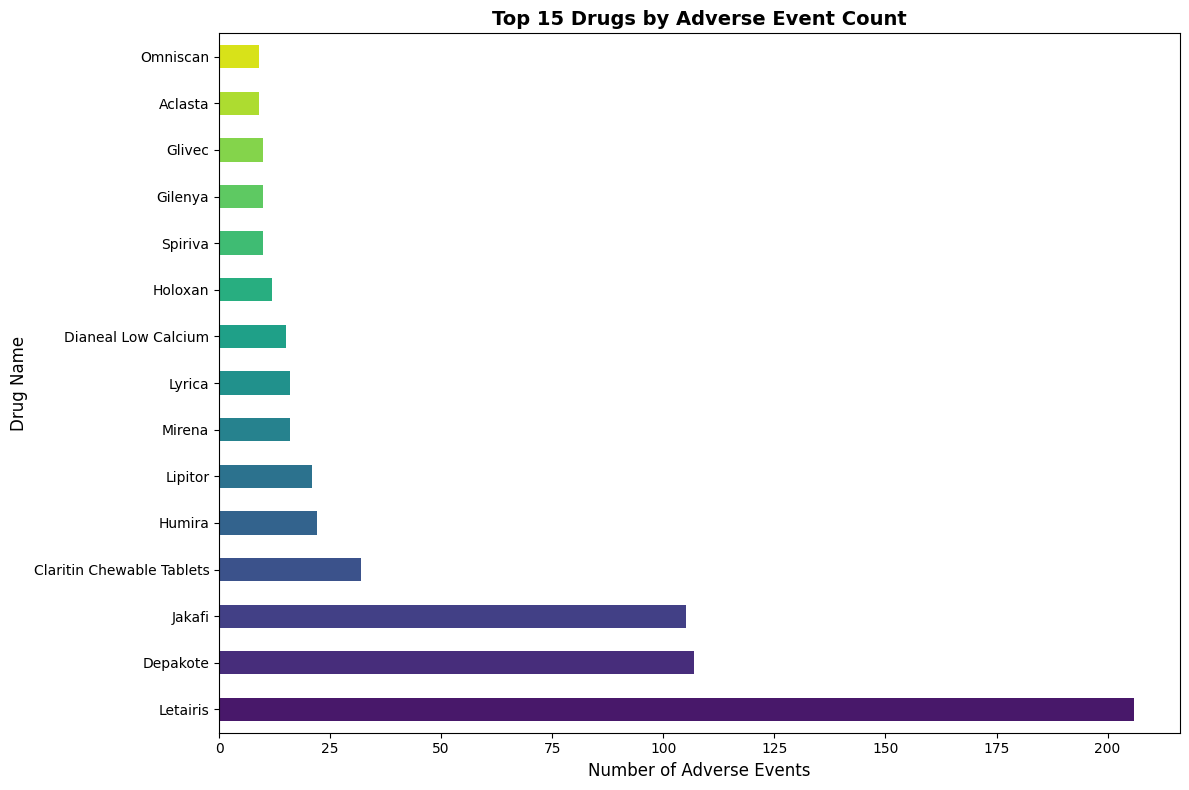


✓ Saved: top_drugs_by_events.png


In [83]:
# Drug adverse events - Top drugs
if drug_ae_cleaned is not None and 'drug_product_name_cleaned' in drug_ae_cleaned.columns:
    top_drugs = drug_ae_cleaned['drug_product_name_cleaned'].dropna().value_counts().head(15)

    if len(top_drugs) > 0:
        plt.figure(figsize=(12, 8))
        top_drugs.plot(kind='barh', color=sns.color_palette('viridis', len(top_drugs)))
        plt.title('Top 15 Drugs by Adverse Event Count', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Adverse Events', fontsize=12)
        plt.ylabel('Drug Name', fontsize=12)
        plt.tight_layout()
        plt.savefig(plot_dir / 'top_drugs_by_events.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: top_drugs_by_events.png")

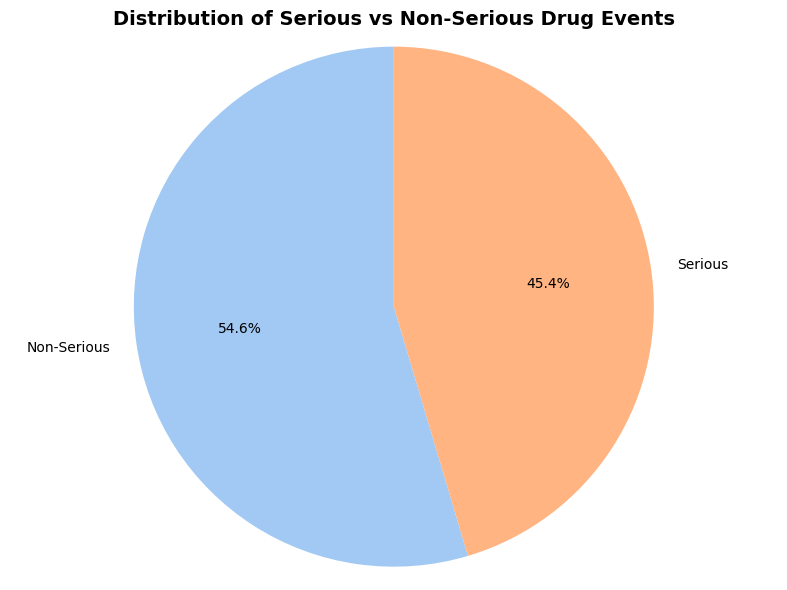


✓ Saved: drug_serious_events_distribution.png


In [84]:
# Serious vs non-serious drug events
if drug_ae_cleaned is not None and 'serious_binary' in drug_ae_cleaned.columns:
    serious_counts = drug_ae_cleaned['serious_binary'].value_counts()

    if len(serious_counts) > 0:
        plt.figure(figsize=(8, 6))
        labels = ['Non-Serious', 'Serious']
        colors = sns.color_palette('pastel')[0:len(serious_counts)]
        plt.pie(serious_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Distribution of Serious vs Non-Serious Drug Events', fontsize=14, fontweight='bold')
        plt.ylabel('')
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.tight_layout()
        plt.savefig(plot_dir / 'drug_serious_events_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: drug_serious_events_distribution.png")

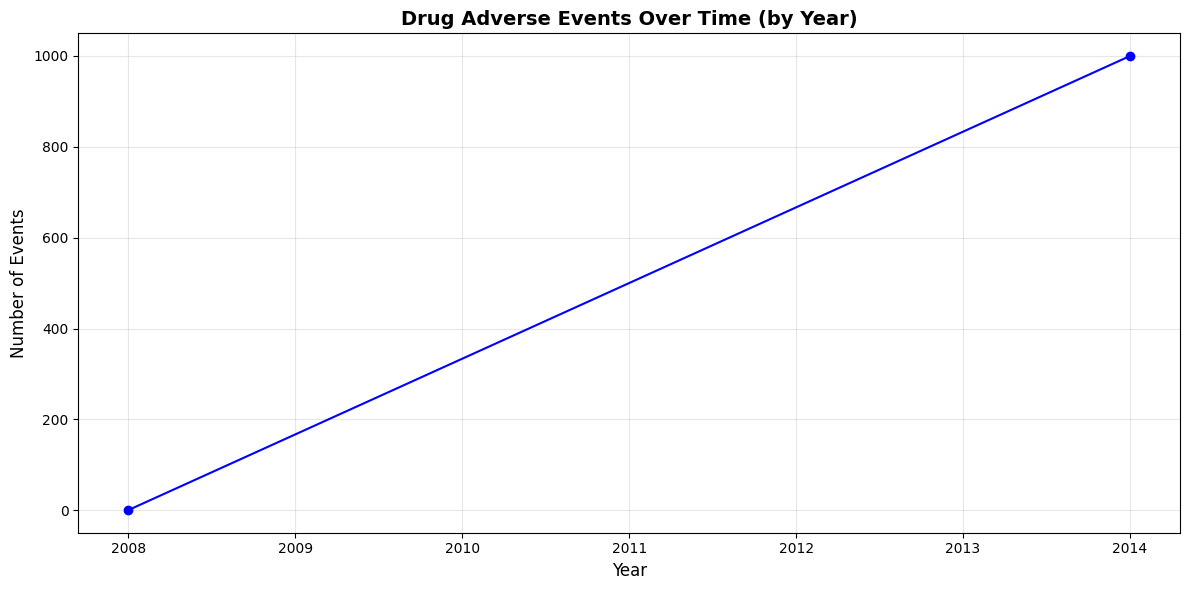


✓ Saved: drug_events_over_time_yearly.png


In [85]:
# Drug events over time (by year)
if drug_ae_cleaned is not None and 'year' in drug_ae_cleaned.columns:
    events_by_year = drug_ae_cleaned['year'].dropna().value_counts().sort_index()

    if len(events_by_year) > 0:
        plt.figure(figsize=(12, 6))
        events_by_year.plot(kind='line', marker='o', color='blue')
        plt.title('Drug Adverse Events Over Time (by Year)', fontsize=14, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Number of Events', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(plot_dir / 'drug_events_over_time_yearly.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: drug_events_over_time_yearly.png")

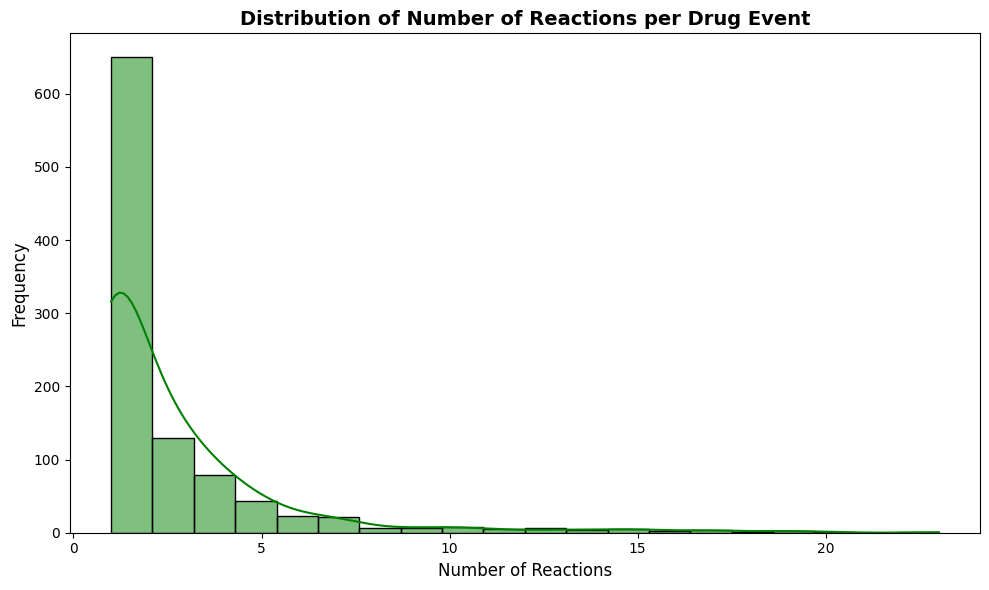


✓ Saved: drug_reaction_count_distribution.png


In [86]:
# Reaction count distribution (Drug)
if drug_ae_cleaned is not None and 'reaction_count' in drug_ae_cleaned.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(drug_ae_cleaned['reaction_count'], bins=20, kde=True, color='green')
    plt.title('Distribution of Number of Reactions per Drug Event', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Reactions', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.savefig(plot_dir / 'drug_reaction_count_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Saved: drug_reaction_count_distribution.png")

## Biologics Graphs

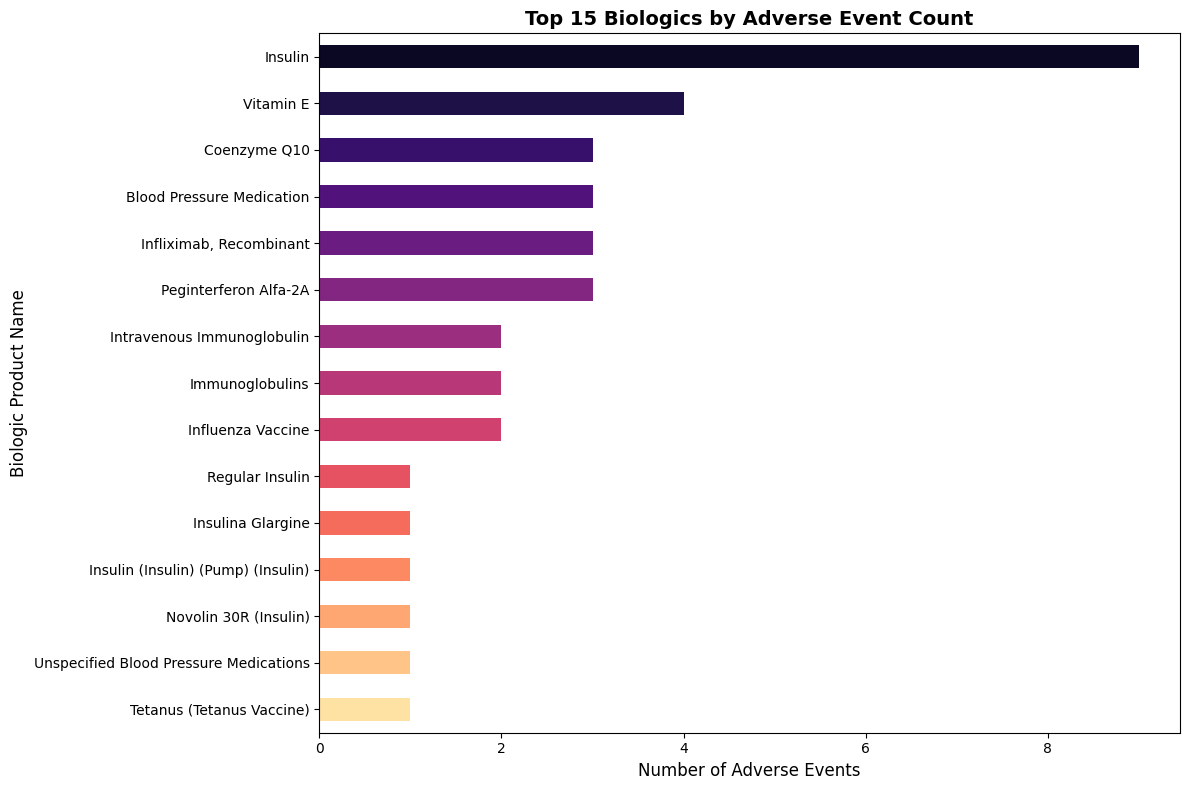


✓ Saved: top_biologics_by_events.png


In [87]:
# Biologics adverse events - Top biologics
if biologics_ae_cleaned is not None and 'biologics_product_name_cleaned' in biologics_ae_cleaned.columns:
    top_biologics = biologics_ae_cleaned['biologics_product_name_cleaned'].dropna().value_counts().head(15)

    if len(top_biologics) > 0:
        plt.figure(figsize=(12, 8))
        top_biologics.plot(kind='barh', color=sns.color_palette('magma', len(top_biologics)))
        plt.title('Top 15 Biologics by Adverse Event Count', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Adverse Events', fontsize=12)
        plt.ylabel('Biologic Product Name', fontsize=12)
        plt.gca().invert_yaxis() # Show highest count at the top
        plt.tight_layout()
        plt.savefig(plot_dir / 'top_biologics_by_events.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: top_biologics_by_events.png")
    else:
        print("\nNo biologics product name data available for plotting.")

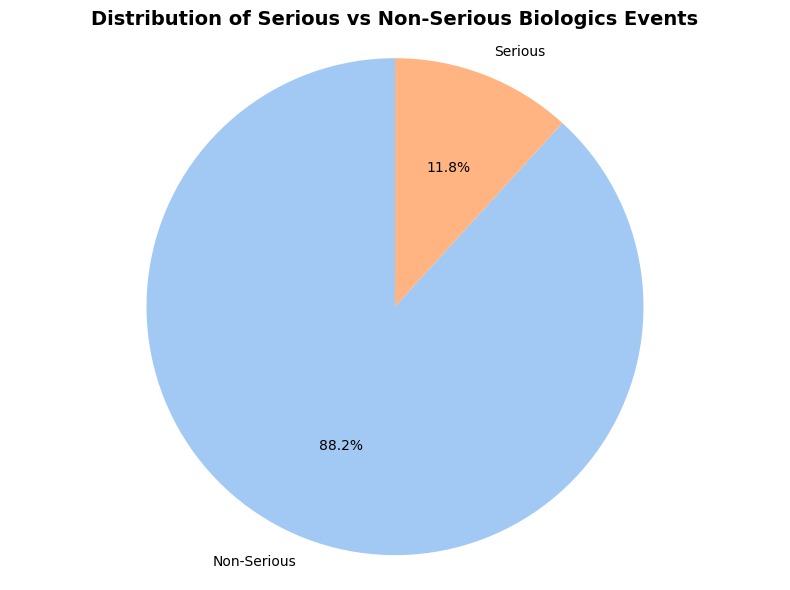


✓ Saved: biologics_serious_events_distribution.png


In [88]:
# Serious vs non-serious biologics events
if biologics_ae_cleaned is not None and 'serious_binary' in biologics_ae_cleaned.columns:
    serious_counts_biologics = biologics_ae_cleaned['serious_binary'].value_counts()

    if len(serious_counts_biologics) > 0:
        plt.figure(figsize=(8, 6))
        labels = ['Non-Serious', 'Serious'] if len(serious_counts_biologics) == 2 else serious_counts_biologics.index
        colors = sns.color_palette('pastel')[0:len(serious_counts_biologics)]
        plt.pie(serious_counts_biologics, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Distribution of Serious vs Non-Serious Biologics Events', fontsize=14, fontweight='bold')
        plt.ylabel('')
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.tight_layout()
        plt.savefig(plot_dir / 'biologics_serious_events_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: biologics_serious_events_distribution.png")
    else:
         print("\nNo serious event data available for biologics plotting.")


## Device Visualizations

In [89]:
# Top devices by events (Ensure uses cleaned data)
if device_ae_cleaned is not None and 'device_name_cleaned' in device_ae_cleaned.columns:
    top_devices = device_ae_cleaned['device_name_cleaned'].dropna().value_counts().head(15)

    if len(top_devices) > 0 and top_devices.index[0] != 'Nan': # Check if there are meaningful device names
        plt.figure(figsize=(12, 8))
        top_devices.plot(kind='barh', color=sns.color_palette('plasma', len(top_devices)))
        plt.title('Top 15 Medical Devices by Adverse Event Count', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Adverse Events', fontsize=12)
        plt.ylabel('Device Name', fontsize=12)
        plt.gca().invert_yaxis() # Show highest count at the top
        plt.tight_layout()
        plt.savefig(plot_dir / 'top_devices_by_events.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: top_devices_by_events.png")
    else:
        print("\nNo meaningful device name data available for plotting.")


No meaningful device name data available for plotting.


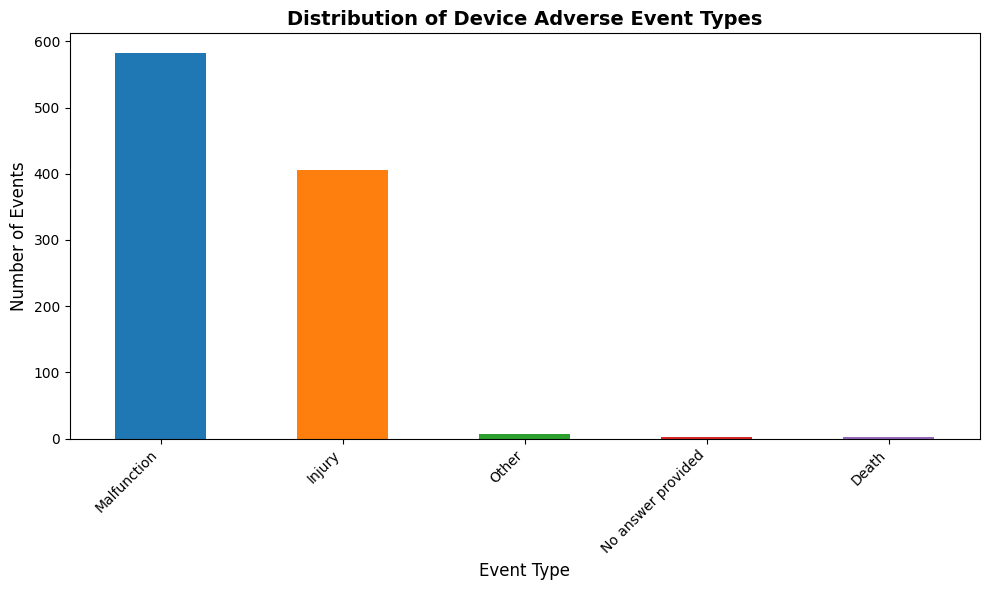


✓ Saved: device_event_type_distribution.png


In [90]:
# Device adverse event types distribution
if device_ae_cleaned is not None and 'event_type' in device_ae_cleaned.columns:
    event_type_counts_device = device_ae_cleaned['event_type'].value_counts()

    if len(event_type_counts_device) > 0:
        plt.figure(figsize=(10, 6))
        event_type_counts_device.plot(kind='bar', color=sns.color_palette('tab10', len(event_type_counts_device)))
        plt.title('Distribution of Device Adverse Event Types', fontsize=14, fontweight='bold')
        plt.xlabel('Event Type', fontsize=12)
        plt.ylabel('Number of Events', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(plot_dir / 'device_event_type_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: device_event_type_distribution.png")
    else:
        print("\nNo event type data available for device plotting.")

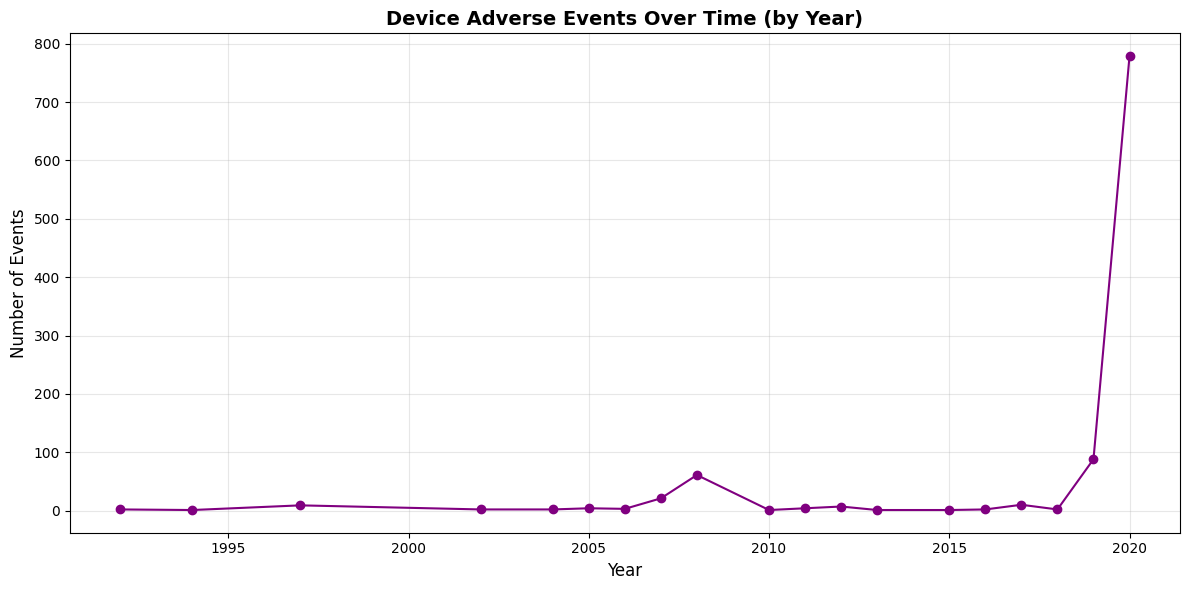


✓ Saved: device_events_over_time_yearly.png


In [91]:
# Device events over time (by year)
if device_ae_cleaned is not None and 'report_year' in device_ae_cleaned.columns: # Assuming 'report_year' was created in analysis step
    device_events_by_year = device_ae_cleaned['report_year'].dropna().value_counts().sort_index()

    if len(device_events_by_year) > 0:
        plt.figure(figsize=(12, 6))
        device_events_by_year.plot(kind='line', marker='o', color='purple')
        plt.title('Device Adverse Events Over Time (by Year)', fontsize=14, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Number of Events', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(plot_dir / 'device_events_over_time_yearly.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: device_events_over_time_yearly.png")
    else:
        print("\nNo year data available for device events over time plotting.")

## Recalls Graphs

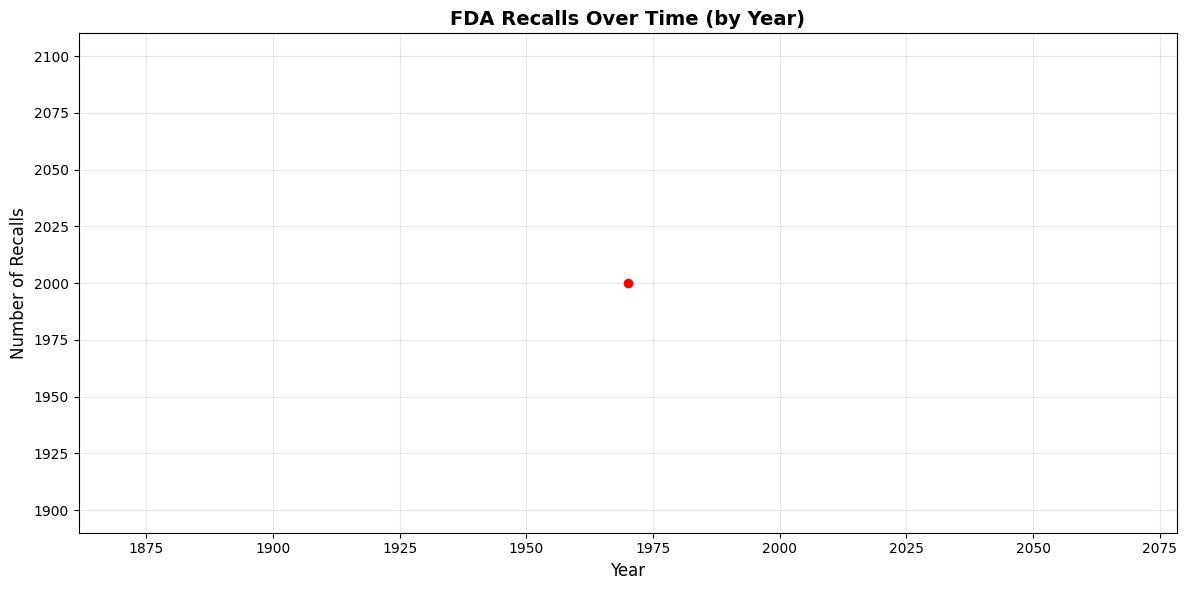


✓ Saved: recalls_over_time_yearly.png


In [92]:
# Recalls over time (by year)
if recalls_cleaned is not None and 'year' in recalls_cleaned.columns:
    recalls_by_year = recalls_cleaned['year'].dropna().value_counts().sort_index()

    if len(recalls_by_year) > 0:
        plt.figure(figsize=(12, 6))
        recalls_by_year.plot(kind='line', marker='o', color='red')
        plt.title('FDA Recalls Over Time (by Year)', fontsize=14, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Number of Recalls', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(plot_dir / 'recalls_over_time_yearly.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: recalls_over_time_yearly.png")

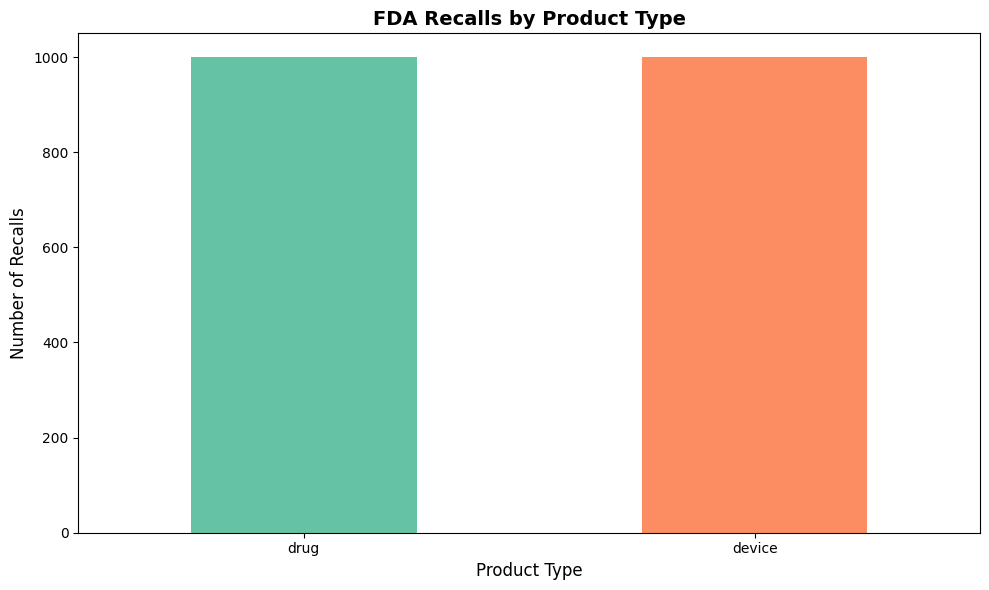


✓ Saved: recalls_by_product_type_bar.png


In [93]:
# Product types in recalls
if recalls_cleaned is not None and 'product_type' in recalls_cleaned.columns:
    product_types = recalls_cleaned['product_type'].value_counts() # Plot all, not just top 10

    if len(product_types) > 0:
        plt.figure(figsize=(10, 6))
        product_types.plot(kind='bar', color=sns.color_palette('Set2', len(product_types)))
        plt.title('FDA Recalls by Product Type', fontsize=14, fontweight='bold')
        plt.xlabel('Product Type', fontsize=12)
        plt.ylabel('Number of Recalls', fontsize=12)
        plt.xticks(rotation=0) # Keep labels horizontal for few categories
        plt.tight_layout()
        plt.savefig(plot_dir / 'recalls_by_product_type_bar.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n✓ Saved: recalls_by_product_type_bar.png")

In [94]:
print(f"\n✓ All plots saved to: {plot_dir}")


✓ All plots saved to: /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_recalls_analysis_plots


## Summary:

### Data Analysis Key Findings

#### Drug Adverse Events

* The Drug data contains 1000 rows and 17 columns.
* drug_generic_name column is entirely missing. Other columns like seriousnessdisabling, seriousnesslifethreatening, `seriousnessdeath, seriousnesshospitalization, patient_age, patient_age_unit, drug_brand_name, outcome, and patient_sex also have missing values to varying degrees.
* All 1000 records have values for drug_product_name and adverse_reactions.
* There are 268 unique drug products in the dataset.
* The majority of drug adverse events are classified as non-serious (54.6% are '2', while 45.4% are '1', assuming '1' is serious). The serious event rate based on the 'serious' column value of '1' is 45.40%.
* There are 917 unique adverse reaction types reported for drug events. The most common reactions include Dyspnoea, Drug ineffective, Headache, Fatigue, and Diarrhoea.
* The number of reactions per drug event varies, with a mean of 2.75 and a maximum of 23.
* The receivedate column was successfully parsed, showing data primarily from 2008 and 2014, with a significant concentration in 2014.
* Approximately 65.9% of records have valid patient age information, with an average age of around 54.7 years.
* Patient sex distribution shows females (2.0) being more represented than males (1.0), with a notable count of '0.0' entries.

#### Device Adverse Events

* The Device data contains 1000 rows and 12 columns, with significant missing values in columns like event_key, device_product_code, and device_problem.
* All 1000 records in device_ae_cleaned have a value in device_name_cleaned, but only one unique value ('Nan') was found, indicating a potential issue with device name cleaning or data quality.
* For device adverse events, 'Malfunction' and 'Injury' are the most frequent event types.
* No non-missing device problem information was available in the device_ae_cleaned dataset.
* Device adverse events show significant year-over-year changes, with notable increases (e.g., >50%) observed in 2019 and 2020.
* The visualization for top medical devices by adverse event count was not generated due to a lack of meaningful data (only 'Nan' values) in the cleaned device names column.

#### Biologics Adverse Events

* The biologics_ae_df DataFrame contains 51 records and 14 columns, with missing values primarily in generic and brand names.
* 88.24% of biologics adverse events in the sample are classified as serious.
* 'Pyrexia' is the most common adverse reaction reported for biologics, among 149 unique reaction types found in the small sample.
* Biologics adverse event reports in the sample are limited to a short date range in 2014, preventing meaningful trend analysis over time.

### Insights or Next Steps

* Investigate the cleaning process for device_name_cleaned to understand why only 'Nan' values are present and explore alternative methods or data sources for identifying specific devices.
* Acknowledge the limitations of the biologics analysis due to the small sample size and limited date range, and note that a more comprehensive analysis would require a larger, more diverse dataset.
* Further investigate the meaning of the 'serious' column values and the patient sex values (0.0, 1.0, 2.0) in the drug data for clearer interpretation.
* Consider performing more advanced text analysis on the 'adverse_reactions' and 'reason_for_recall' columns to identify common themes and patterns beyond simple word counts.